In [1]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

# Import the ras-commander package
from ras_commander import *

# Manning's n Sensitivity Analysis: Multi-Interval Approach

## Overview

This notebook demonstrates advanced Manning's n sensitivity analysis for HEC-RAS 2D models using the `ras-commander` library. It provides two complementary approaches to assess the impact of roughness parameter variations on model results:

1. **Base Override Sensitivity**: Varies Manning's n values for individual land cover types in the base mesh roughness
2. **Regional Override Sensitivity**: Varies Manning's n values for land cover types within defined calibration regions

## Key Features

- **Literature-Based Ranges**: Uses documented Manning's n ranges for various land cover types
- **Intelligent Filtering**: Automatically identifies significant land uses based on area coverage thresholds
- **Multi-Interval Testing**: Tests multiple Manning's n values at specified intervals within the literature range
- **Parallel Execution**: Efficiently runs multiple scenarios using HEC-RAS parallel computing
- **Comprehensive Visualization**: Generates sensitivity plots and time series comparisons
- **Automated Reporting**: Creates CSV summaries and exports results for further analysis

## Notebook Structure

### Part 1: Setup and Configuration
- Environment setup and imports
- Manning's n range definitions
- Helper functions for sensitivity analysis

### Part 2: Base Override Sensitivity Analysis
- Analysis of land cover statistics for the entire 2D mesh
- Sensitivity testing by varying individual land cover Manning's n values
- Results extraction and visualization

### Part 3: Regional Override Sensitivity Analysis
- Focus on specific calibration regions within the mesh
- Analysis of main channel or other regional overrides
- Targeted sensitivity testing for regional parameters

## Navigation Tips

- Use the table of contents or search for "# Part" to jump between major sections
- Each analysis section includes execution examples with the BaldEagleCrkMulti2D sample project
- Results are displayed with both plots and summary tables for easy interpretation


##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# Part 1: Setup and Configuration

## Important Note on DataFrame Column Naming

**Column Naming Convention in ras-commander:**

The `ras-commander` library uses simplified column names in DataFrames for Manning's n values:

- **DataFrame column**: `Mannings n` (no apostrophe)
- **HEC-RAS HDF files**: `Manning's n` (with apostrophe - official technical term)

This design decision simplifies DataFrame operations by avoiding special characters in column names, while HEC-RAS's internal HDF structure retains the technically correct spelling with the apostrophe.

**Key Point**: When working with Manning's n values from `ras-commander`, always reference the column as `Mannings n` (without apostrophe) in your DataFrame operations.

In [2]:
## Standard Library and Third-Party Imports

import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point
import math

# Configure matplotlib for inline display in Jupyter
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Define the mannings n max and min values as a range. 

manning_data = [
    {"Land Cover Name": "NoData", "min_n": 0.050, "max_n": 0.070},
    {"Land Cover Name": "Barren Land Rock/Sand/Clay", "min_n": 0.023, "max_n": 0.100},
    {"Land Cover Name": "Cultivated Crops", "min_n": 0.020, "max_n": 0.100},
    {"Land Cover Name": "Deciduous Forest", "min_n": 0.100, "max_n": 0.200},
    {"Land Cover Name": "Developed, High Intensity", "min_n": 0.120, "max_n": 0.200},
    {"Land Cover Name": "Developed, Low Intensity", "min_n": 0.060, "max_n": 0.120},
    {"Land Cover Name": "Developed, Medium Intensity", "min_n": 0.080, "max_n": 0.160},
    {"Land Cover Name": "Developed, Open Space", "min_n": 0.030, "max_n": 0.090},
    {"Land Cover Name": "Emergent Herbaceous Wetlands", "min_n": 0.050, "max_n": 0.120},
    {"Land Cover Name": "Evergreen Forest", "min_n": 0.080, "max_n": 0.160},
    {"Land Cover Name": "Grassland/Herbaceous", "min_n": 0.025, "max_n": 0.070},
    {"Land Cover Name": "Mixed Forest", "min_n": 0.080, "max_n": 0.200},
    {"Land Cover Name": "Open Water", "min_n": 0.025, "max_n": 0.050},
    {"Land Cover Name": "Pasture/Hay", "min_n": 0.025, "max_n": 0.090},
    {"Land Cover Name": "Shrub/Scrub", "min_n": 0.070, "max_n": 0.160},
    {"Land Cover Name": "Woody Wetlands", "min_n": 0.045, "max_n": 0.150}
]

# Create DataFrame
manning_minmax_df = pd.DataFrame(manning_data)

# Calculate the midpoint value
manning_minmax_df['mid_n'] = (manning_minmax_df['min_n'] + manning_minmax_df['max_n']) / 2

# Sort by land cover name
manning_minmax_df = manning_minmax_df.sort_values('Land Cover Name').reset_index(drop=True)

# Print summary information
print(f"Manning's n value ranges for {len(manning_minmax_df)} land cover types:")
print(manning_minmax_df)



Manning's n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n   mid_n
0     Barren Land Rock/Sand/Clay  0.023   0.10  0.0615
1               Cultivated Crops  0.020   0.10  0.0600
2               Deciduous Forest  0.100   0.20  0.1500
3      Developed, High Intensity  0.120   0.20  0.1600
4       Developed, Low Intensity  0.060   0.12  0.0900
5    Developed, Medium Intensity  0.080   0.16  0.1200
6          Developed, Open Space  0.030   0.09  0.0600
7   Emergent Herbaceous Wetlands  0.050   0.12  0.0850
8               Evergreen Forest  0.080   0.16  0.1200
9           Grassland/Herbaceous  0.025   0.07  0.0475
10                  Mixed Forest  0.080   0.20  0.1400
11                        NoData  0.050   0.07  0.0600
12                    Open Water  0.025   0.05  0.0375
13                   Pasture/Hay  0.025   0.09  0.0575
14                   Shrub/Scrub  0.070   0.16  0.1150
15                Woody Wetlands  0.045   0.15  0.0975


## Helper Functions for Sensitivity Analysis

The following functions support the sensitivity analysis workflow by:
1. **Analyzing land cover statistics** in the 2D mesh
2. **Generating test values** at specified intervals
3. **Estimating plan counts** to avoid exceeding HEC-RAS limits

These utilities are used by both base and regional override sensitivity functions.


In [4]:
def analyze_mesh_land_cover_statistics(project_folder, geom_number=None, plan_number=None):
    """
    Analyze the land cover statistics for a 2D mesh area in a HEC-RAS model,
    excluding areas controlled by regional Manning's n overrides.
    
    Args:
        project_folder (str): Path to the HEC-RAS project folder
        geom_number (str, optional): Geometry number to use. If None, will use
                                    geometry from plan_number or the first geometry.
        plan_number (str, optional): Plan number to use. If None, will use the first plan.
    
    Returns:
        pd.DataFrame: DataFrame with land cover statistics for areas controlled by base overrides
    """
    # Initialize RAS project
    ras = init_ras_project(project_folder, "6.6")
        
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'full_path'].values[0]
    
    # Get the geometry HDF path
    geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]
    
    # Get mesh areas from the geometry
    mesh_areas_gdf = HdfMesh.get_mesh_areas(geom_hdf_path)
    num_mesh_areas = len(mesh_areas_gdf)
    
    # Get the base Manning's overrides to compare with land cover statistics
    base_overrides = RasGeo.get_mannings_baseoverrides(geom_path)
    
    # Get regional override information
    region_overrides = RasGeo.get_mannings_regionoverrides(geom_path)
    regional_mask = None
    
    # If regional overrides exist, get their geometries to exclude them
    if not region_overrides.empty:
        print("Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis")
        # Get regional override polygons from the geometry
        regional_polygons_gdf = get_regional_override_polygons(geom_hdf_path)
        
        if not regional_polygons_gdf.empty:
            # Create a union of all regional override polygons to use as a mask
            regional_mask = regional_polygons_gdf.unary_union
            print(f"Excluding {len(regional_polygons_gdf)} regional override areas from analysis")
    
    all_results = {}
    
    for idx, row in mesh_areas_gdf.iterrows():
        mesh_name = row['mesh_name']
        mesh_geom = row['geometry']
        
        print(f"Analyzing land cover for mesh area: {mesh_name}")
        
        # Get effective mesh area (excluding regional overrides)
        effective_mesh_geom = mesh_geom
        if regional_mask is not None:
            if mesh_geom.intersects(regional_mask):
                effective_mesh_geom = mesh_geom.difference(regional_mask)
                print(f"  Excluded regional override areas from mesh {mesh_name}")
        
        total_area = effective_mesh_geom.area
        
        # Create a simulated land cover distribution based on base_overrides
        # In reality, you would use actual spatial analysis with the land cover raster
        landcover_stats = []
        
        # Use the land cover types from the base overrides
        for _, override_row in base_overrides.iterrows():
            land_cover = override_row['Land Cover Name']
            n_value = override_row["Base Manning's n Value"]
            
            # Generate a random percentage for this example
            # In reality, this would come from actual spatial analysis
            np.random.seed(hash(land_cover) % 2**32)  # Use the land cover name as a seed
            percentage = np.random.random() * 25  # Random percentage between 0-25%
            
            area = total_area * (percentage / 100)
            
            landcover_stats.append({
                'Land Cover Type': land_cover,
                'Area': area,
                'Percentage': percentage,
                'Current_n': n_value
            })
        
        # Create DataFrame and sort by percentage
        landcover_df = pd.DataFrame(landcover_stats)
        landcover_df = landcover_df.sort_values('Percentage', ascending=False).reset_index(drop=True)
        
        # Store the results
        all_results[mesh_name] = landcover_df
    
    # If there's only one mesh area, return its dataframe directly
    if len(all_results) == 1:
        return next(iter(all_results.values()))
    
    return all_results

def get_regional_override_polygons(geom_hdf_path):
    """
    Extract regional override polygon geometries from a HEC-RAS geometry HDF file.
    
    Args:
        geom_hdf_path (str): Path to the HEC-RAS geometry HDF file
        
    Returns:
        geopandas.GeoDataFrame: GeoDataFrame with regional override polygons
    """
    import h5py
    import geopandas as gpd
    from shapely.geometry import Polygon
    
    try:
        with h5py.File(geom_hdf_path, 'r') as f:
            # Navigate to regional override polygons in the HDF structure
            # This path would need to be determined based on the HEC-RAS HDF structure
            if 'Geometry/Regional Manning Areas' in f:
                region_group = f['Geometry/Regional Manning Areas']
                
                polygons = []
                region_names = []
                
                # Process each regional override polygon
                for region_name, region_data in region_group.items():
                    # Extract polygon coordinates
                    # This is a simplified example; actual implementation would depend on HDF structure
                    if 'Polygon' in region_data:
                        coords = region_data['Polygon'][:]
                        polygon = Polygon(coords)
                        polygons.append(polygon)
                        region_names.append(region_name)
                
                # Create GeoDataFrame
                if polygons:
                    gdf = gpd.GeoDataFrame(
                        {'region_name': region_names, 'geometry': polygons},
                        crs='EPSG:4326'  # Set appropriate CRS
                    )
                    return gdf
        
        # Return empty GeoDataFrame if no regional overrides found
        return gpd.GeoDataFrame(columns=['region_name', 'geometry'])
        
    except Exception as e:
        print(f"Error extracting regional override polygons: {str(e)}")
        return gpd.GeoDataFrame(columns=['region_name', 'geometry'])

In [5]:
def generate_sensitivity_values(min_val, max_val, current_val, interval=0.01):
    """
    Generate a list of Manning's n values for sensitivity testing.
    
    Args:
        min_val (float): Minimum value from literature
        max_val (float): Maximum value from literature
        current_val (float): Current value in the model
        interval (float): Interval between test values
    
    Returns:
        list: List of n values to test
    """
    # Round values to avoid floating point issues
    min_val = round(min_val, 4)
    max_val = round(max_val, 4)
    current_val = round(current_val, 4)
    interval = round(interval, 4)
    
    # Generate values from min to max at specified interval
    all_values = np.arange(min_val, max_val + interval/2, interval)
    all_values = np.round(all_values, 4)  # Round to avoid floating point issues
    
    # Remove current value if it's in the range
    values = [val for val in all_values if abs(val - current_val) > interval/2]
    
    # Make sure current value is not in the list
    if current_val in values:
        values.remove(current_val)
    
    return values

def estimate_plan_count(significant_landuses, n_ranges, interval=0.01):
    """
    Estimate the number of plans that will be created for sensitivity analysis.
    
    Args:
        significant_landuses (pd.DataFrame): DataFrame with significant land cover types
        n_ranges (pd.DataFrame): DataFrame with Manning's n ranges
        interval (float): Interval between test values
    
    Returns:
        int: Estimated number of plans
    """
    total_plans = 0
    
    for _, landuse in significant_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        current_n = landuse['Current_n']
        
        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
        if match.empty:
            continue
            
        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]
        
        # Count values between min and max at interval spacing, excluding current value
        values = generate_sensitivity_values(min_n, max_n, current_n, interval)
        total_plans += len(values)
    
    return total_plans

In [6]:
def analyze_mesh_land_cover_statistics(project_folder, geom_number=None, plan_number=None):
    """
    Analyze the land cover statistics for a 2D mesh area in a HEC-RAS model,
    excluding areas controlled by regional Manning's n overrides.
    
    Args:
        project_folder (str): Path to the HEC-RAS project folder
        geom_number (str, optional): Geometry number to use. If None, will use
                                    geometry from plan_number or the first geometry.
        plan_number (str, optional): Plan number to use. If None, will use the first plan.
    
    Returns:
        pd.DataFrame: DataFrame with land cover statistics for areas controlled by base overrides
    """
    # Initialize RAS project
    ras = init_ras_project(project_folder, "6.6")
    
    # [existing code to get geometry number and paths]
    
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'full_path'].values[0]
    
    # Get the geometry HDF path
    geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]
    
    # Get mesh areas from the geometry
    mesh_areas_gdf = HdfMesh.get_mesh_areas(geom_hdf_path)
    num_mesh_areas = len(mesh_areas_gdf)
    
    # Get the base Manning's overrides to compare with land cover statistics
    base_overrides = RasGeo.get_mannings_baseoverrides(geom_path)
    
    # Get regional override information
    region_overrides = RasGeo.get_mannings_regionoverrides(geom_path)
    regional_mask = None
    
    # If regional overrides exist, get their geometries to exclude them
    if not region_overrides.empty:
        print("Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis")
        # Get regional override polygons from the geometry
        regional_polygons_gdf = get_regional_override_polygons(geom_hdf_path)
        
        if not regional_polygons_gdf.empty:
            # Create a union of all regional override polygons to use as a mask
            regional_mask = regional_polygons_gdf.unary_union
            print(f"Excluding {len(regional_polygons_gdf)} regional override areas from analysis")
    
    all_results = {}
    
    for idx, row in mesh_areas_gdf.iterrows():
        mesh_name = row['mesh_name']
        mesh_geom = row['geometry']
        
        print(f"Analyzing land cover for mesh area: {mesh_name}")
        
        # Get effective mesh area (excluding regional overrides)
        effective_mesh_geom = mesh_geom
        if regional_mask is not None:
            if mesh_geom.intersects(regional_mask):
                effective_mesh_geom = mesh_geom.difference(regional_mask)
                print(f"  Excluded regional override areas from mesh {mesh_name}")
        
        total_area = effective_mesh_geom.area
        
        # Create a simulated land cover distribution based on base_overrides
        # In reality, you would use actual spatial analysis with the land cover raster
        landcover_stats = []
        
        # Use the land cover types from the base overrides
        for _, override_row in base_overrides.iterrows():
            land_cover = override_row['Land Cover Name']
            n_value = override_row["Base Mannings n Value"]
            
            # Generate a random percentage for this example
            # In reality, this would come from actual spatial analysis
            np.random.seed(hash(land_cover) % 2**32)  # Use the land cover name as a seed
            percentage = np.random.random() * 25  # Random percentage between 0-25%
            
            area = total_area * (percentage / 100)
            
            landcover_stats.append({
                'Land Cover Type': land_cover,
                'Area': area,
                'Percentage': percentage,
                'Current_n': n_value
            })
        
        # Create DataFrame and sort by percentage
        landcover_df = pd.DataFrame(landcover_stats)
        landcover_df = landcover_df.sort_values('Percentage', ascending=False).reset_index(drop=True)
        
        # Store the results
        all_results[mesh_name] = landcover_df
    
    # If there's only one mesh area, return its dataframe directly
    if len(all_results) == 1:
        return next(iter(all_results.values()))
    
    return all_results

def get_regional_override_polygons(geom_hdf_path):
    """
    Extract regional override polygon geometries from a HEC-RAS geometry HDF file.
    
    Args:
        geom_hdf_path (str): Path to the HEC-RAS geometry HDF file
        
    Returns:
        geopandas.GeoDataFrame: GeoDataFrame with regional override polygons
    """
    import h5py
    import geopandas as gpd
    from shapely.geometry import Polygon
    
    try:
        with h5py.File(geom_hdf_path, 'r') as f:
            # Navigate to regional override polygons in the HDF structure
            # This path would need to be determined based on the HEC-RAS HDF structure
            if 'Geometry/Regional Manning Areas' in f:
                region_group = f['Geometry/Regional Manning Areas']
                
                polygons = []
                region_names = []
                
                # Process each regional override polygon
                for region_name, region_data in region_group.items():
                    # Extract polygon coordinates
                    # This is a simplified example; actual implementation would depend on HDF structure
                    if 'Polygon' in region_data:
                        coords = region_data['Polygon'][:]
                        polygon = Polygon(coords)
                        polygons.append(polygon)
                        region_names.append(region_name)
                
                # Create GeoDataFrame
                if polygons:
                    gdf = gpd.GeoDataFrame(
                        {'region_name': region_names, 'geometry': polygons},
                        crs='EPSG:4326'  # Set appropriate CRS
                    )
                    return gdf
        
        # Return empty GeoDataFrame if no regional overrides found
        return gpd.GeoDataFrame(columns=['region_name', 'geometry'])
        
    except Exception as e:
        print(f"Error extracting regional override polygons: {str(e)}")
        return gpd.GeoDataFrame(columns=['region_name', 'geometry'])

# Part 2: Base Override Sensitivity Analysis

## Overview

Base override sensitivity analysis varies Manning's n values for individual land cover types across the entire 2D mesh area. This approach is appropriate when:
- Evaluating the impact of global land cover roughness changes
- Calibrating models with uniform land cover distributions
- Assessing which land cover types have the greatest influence on results

The analysis automatically:
1. Identifies land covers exceeding the area coverage threshold
2. Generates test scenarios at specified intervals within literature ranges
3. Executes plans in parallel
4. Extracts results at a point of interest
5. Creates sensitivity plots and time series comparisons

## Function: individual_landuse_sensitivity_base()

This function performs the complete base override sensitivity workflow.


In [7]:
def individual_landuse_sensitivity_base(
    project_folder,
    template_plan,
    point_of_interest,
    area_threshold=10.0,  # percentage threshold for significant land uses
    interval=0.01,
    max_workers=2,
    num_cores=2,
    output_folder="Individual_Landuse_Sensitivity",
    n_ranges=None
):
    """
    Perform sensitivity analysis by varying individual land use Manning's n values
    in the base overrides.

    Args:
        project_folder (str): Path to HEC-RAS project folder
        template_plan (str): Plan number to use as template
        point_of_interest (tuple or Point): Coordinates for extracting results
        area_threshold (float): Percentage threshold for significant land uses
        interval (float): Interval for Manning's n test values
        max_workers (int): Number of parallel workers
        num_cores (int): Number of cores per worker
        output_folder (str): Name of output folder
        n_ranges (pd.DataFrame): DataFrame containing min/max Manning's n values.
                                    Must contain columns: 'Land Cover Name', 'min_n', 'max_n'

    Returns:
        dict: Results of sensitivity analysis
    """
    import time
    from datetime import datetime

    # Convert point_of_interest to Point if not already
    if not isinstance(point_of_interest, Point):
        point_of_interest = Point(point_of_interest[0], point_of_interest[1])

    # Verify n_ranges is provided
    if n_ranges is None:
        raise ValueError("n_ranges DataFrame must be provided")

    # Create timestamp for unique run identifier
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Initialize RAS project
    print(f"Initializing HEC-RAS project: {project_folder}")
    ras = init_ras_project(project_folder, "6.6")

    # Create output directory
    results_dir = Path(project_folder) / output_folder
    results_dir.mkdir(exist_ok=True)
    print(f"Results will be saved to: {results_dir}")

    # Verify template plan exists
    if template_plan not in ras.plan_df['plan_number'].values:
        raise ValueError(f"Template plan {template_plan} not found in project")

    # Get the geometry number for the template plan
    template_geom = ras.plan_df.loc[ras.plan_df['plan_number'] == template_plan, 'geometry_number'].values[0]
    print(f"\nTemplate plan: {template_plan} (Geometry: {template_geom})")

    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'full_path'].values[0]

    # Get the original Manning's values
    original_baseoverrides = RasGeo.get_mannings_baseoverrides(geom_path)
    original_regionoverrides = RasGeo.get_mannings_regionoverrides(geom_path)

    # Analyze land cover statistics for the 2D mesh areas
    print("\nAnalyzing land cover statistics for the 2D mesh areas...")
    landcover_stats = analyze_mesh_land_cover_statistics(
        project_folder, 
        geom_number=template_geom
    )

    if landcover_stats is None:
        raise ValueError("Could not analyze land cover statistics")

    # Identify significant land uses (above threshold)
    significant_landuses = landcover_stats[landcover_stats['Percentage'] >= area_threshold].copy()
    significant_landuses = significant_landuses.sort_values('Percentage', ascending=False).reset_index(drop=True)

    if len(significant_landuses) == 0:
        print(f"No land uses found with coverage above {area_threshold}% threshold")
        return None

    print(f"\nFound {len(significant_landuses)} significant land uses (>= {area_threshold}% coverage):")
    print(significant_landuses[['Land Cover Type', 'Percentage', 'Current_n']])

    # Check if we'll exceed the plan limit
    current_plan_count = len(ras.plan_df)
    max_plans = 99  # HEC-RAS limit
    remaining_plans = max_plans - current_plan_count

    # Estimate the number of plans needed
    estimated_plan_count = estimate_plan_count(significant_landuses, n_ranges, interval)

    if estimated_plan_count > remaining_plans:
        print(f"\nWARNING: This analysis would create approximately {estimated_plan_count} plans, but only {remaining_plans} more plans can be added (limit is 99)")
        print("Consider adjusting the following to reduce the number of plans:")
        print(f"1. Increase the area threshold (currently {area_threshold}%)")
        print(f"2. Increase the interval between test values (currently {interval})")
        print(f"3. Reduce the min/max ranges for land uses")
        print(f"4. Select fewer land uses to test")

        # Ask for confirmation to continue
        response = input("\nDo you want to continue anyway? (y/n): ")
        if response.lower() != 'y':
            print("Analysis canceled")
            return None

    # Store the current (template) plan as base scenario
    scenarios = [{
        'name': 'Template',
        'plan_number': template_plan,
        'geom_number': template_geom,
        'shortid': 'Template',
        'land_cover': None,
        'n_value': None,
        'description': "Original Manning's n Values"
    }]

    # Function to create a modified plan with adjusted Manning's values for a specific land use
    def create_modified_plan(land_cover, new_n_value):
        # Create a shortid based on land cover and n value
        # Convert land cover name to code (e.g. "Open Water" -> "OW")
        code = ''.join([word[0] for word in land_cover.split() if word[0].isalpha()])
        if not code:
            code = land_cover[:2]
        code = code.upper()

        # Format n value for shortid
        n_str = f"{new_n_value:.3f}".replace(".", "")
        shortid = f"B_{code}_{n_str}"

        print(f"\nCreating plan for '{land_cover}' with n = {new_n_value} (ShortID: {shortid})")

        # Clone the template plan
        new_plan_number = RasPlan.clone_plan(template_plan, new_plan_shortid=shortid)

        # Clone the template geometry
        new_geom_number = RasPlan.clone_geom(template_geom)

        # Set the new plan to use the new geometry
        RasPlan.set_geom(new_plan_number, new_geom_number)

        # Get the new geometry file path
        new_geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == new_geom_number, 'full_path'].values[0]

        # Create modified base overrides
        modified_baseoverrides = original_baseoverrides.copy()

        # Update the Manning's n value for this specific land cover type
        land_cover_mask = modified_baseoverrides['Land Cover Name'] == land_cover
        if land_cover_mask.any():
            current_n = modified_baseoverrides.loc[land_cover_mask, "Base Mannings n Value"].values[0]
            print(f"  Changing '{land_cover}' from {current_n:.4f} to {new_n_value:.4f}")
            modified_baseoverrides.loc[land_cover_mask, "Base Mannings n Value"] = new_n_value
        else:
            print(f"  Warning: Land cover '{land_cover}' not found in base overrides")

        # Apply the modified base overrides
        RasGeo.set_mannings_baseoverrides(new_geom_path, modified_baseoverrides)

        # Copy regional overrides unchanged if they exist
        if not original_regionoverrides.empty:
            RasGeo.set_mannings_regionoverrides(new_geom_path, original_regionoverrides)

        # Store scenario details
        return {
            'name': f"{land_cover}_{new_n_value:.3f}",
            'plan_number': new_plan_number,
            'geom_number': new_geom_number,
            'shortid': shortid,
            'land_cover': land_cover,
            'n_value': new_n_value,
            'description': f"Manning's n = {new_n_value:.3f} for {land_cover}"
        }

    # Create plans for each significant land use with varying n values
    all_plans_to_run = []

    for _, landuse in significant_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        current_n = landuse['Current_n']

        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]

        if match.empty:
            print(f"Warning: No Manning's n range found for '{land_cover}'. Skipping.")
            continue

        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]

        print(f"\nProcessing land cover: {land_cover}")
        print(f"  Current n: {current_n:.4f}")
        print(f"  Literature range: {min_n:.4f} to {max_n:.4f}")

        # Generate test values within the range, excluding the current value
        test_values = generate_sensitivity_values(min_n, max_n, current_n, interval)

        print(f"  Testing {len(test_values)} values: {[round(val, 3) for val in test_values]}")

        # Create a plan for each test value
        for n_value in test_values:
            new_scenario = create_modified_plan(land_cover, n_value)
            scenarios.append(new_scenario)
            all_plans_to_run.append(new_scenario['plan_number'])

    # Save scenario information
    scenario_info = pd.DataFrame(scenarios)
    scenario_info_path = results_dir / "scenarios.csv"
    scenario_info.to_csv(scenario_info_path, index=False)
    print(f"\nScenario information saved to: {scenario_info_path}")

    # Run the plans (excluding the template which is already computed)
    plans_to_run = [plan for plan in all_plans_to_run if plan != template_plan]

    if not plans_to_run:
        print("No plans to run.")
        return {'scenarios': scenarios, 'output_folder': results_dir}

    print(f"\nRunning {len(plans_to_run)} plans in parallel...")
    execution_results = RasCmdr.compute_parallel(
        plan_number=plans_to_run,
        max_workers=max_workers,
        num_cores=num_cores,
        clear_geompre=True
    )

    print("\nExecution results:")
    for plan, success in execution_results.items():
        print(f"  Plan {plan}: {'Successful' if success else 'Failed'}")

    # If point of interest provided, extract and compare results
    if point_of_interest is not None:
        # Get geometry HDF path for cell identification
        geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'hdf_path'].values[0]

        # Find the nearest mesh cell
        mesh_cells_gdf = HdfMesh.get_mesh_cell_points(geom_hdf_path)
        distances = mesh_cells_gdf.geometry.apply(lambda geom: geom.distance(point_of_interest))
        nearest_idx = distances.idxmin()
        mesh_cell_id = mesh_cells_gdf.loc[nearest_idx, 'cell_id']
        mesh_name = mesh_cells_gdf.loc[nearest_idx, 'mesh_name']

        print(f"\nNearest cell ID: {mesh_cell_id}")
        print(f"Distance: {distances[nearest_idx]:.2f} units")
        print(f"Mesh area: {mesh_name}")

        # Extract results for each scenario
        all_results = {}
        max_ws_values = []

        for scenario in scenarios:
            plan_number = scenario['plan_number']
            land_cover = scenario['land_cover']
            n_value = scenario['n_value']
            shortid = scenario['shortid']

            try:
                results_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_number)

                # Extract water surface data
                ws_data = results_xr[mesh_name]['Water Surface'].sel(cell_id=int(mesh_cell_id))

                # Convert to DataFrame
                ws_df = pd.DataFrame({
                    'time': ws_data.time.values,
                    'water_surface': ws_data.values
                })

                # Store results
                max_ws = ws_df['water_surface'].max()

                all_results[plan_number] = {
                    'scenario': scenario,
                    'df': ws_df,
                    'max_water_surface': max_ws
                }

                max_ws_values.append({
                    'plan_number': plan_number,
                    'shortid': shortid,
                    'land_cover': land_cover,
                    'n_value': n_value,
                    'max_water_surface': max_ws
                })

                print(f"  {shortid}: Max WSE = {max_ws:.2f}")

                # Save time series to CSV
                ws_df.to_csv(results_dir / f"timeseries_{shortid}.csv", index=False)

            except Exception as e:
                print(f"  Error extracting results for {shortid}: {str(e)}")

        # Create summary DataFrame
        if max_ws_values:
            max_ws_df = pd.DataFrame(max_ws_values)
            max_ws_df.to_csv(results_dir / "max_water_surface_summary.csv", index=False)

            # Prepare mapping of land cover -> percentage (from significant_landuses)
            lc_percentage_dict = dict(zip(significant_landuses['Land Cover Type'], significant_landuses['Percentage']))

            # Create plots by land cover type
            for land_cover in significant_landuses['Land Cover Type']:
                # Filter scenarios for this land cover
                land_cover_scenarios = max_ws_df[max_ws_df['land_cover'] == land_cover].copy()

                # Add the template scenario
                template_row = max_ws_df[max_ws_df['shortid'] == 'Template']
                if not template_row.empty:
                    land_cover_scenarios = pd.concat([template_row, land_cover_scenarios])

                if land_cover_scenarios.empty:
                    continue

                # Sort by n_value
                land_cover_scenarios = land_cover_scenarios.sort_values('n_value').reset_index(drop=True)

                # Add coverage percentage string to label
                perc = lc_percentage_dict.get(land_cover, None)
                if perc is not None:
                    perc_str = f" ({perc:.1f}% coverage)"
                else:
                    perc_str = ""

                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(land_cover_scenarios['n_value'], land_cover_scenarios['max_water_surface'], 
                         marker='o', linestyle='-', linewidth=2)

                # Add template point in a different color if it exists
                template_idx = land_cover_scenarios[land_cover_scenarios['shortid'] == 'Template'].index
                if not template_idx.empty:
                    ax.scatter(land_cover_scenarios.loc[template_idx, 'n_value'], 
                                land_cover_scenarios.loc[template_idx, 'max_water_surface'],
                                color='red', s=100, zorder=5, label='Template')

                # Add labels and title, showing percentage of coverage
                ax.set_xlabel(f"Manning's n for {land_cover}{perc_str}")
                ax.set_ylabel("Maximum Water Surface Elevation (ft)")
                ax.set_title(f"Sensitivity to {land_cover}{perc_str} Manning's n Value")
                ax.grid(True, linestyle='--', alpha=0.7)

                if not template_idx.empty:
                    ax.legend()

                # Save plot
                plot_path = results_dir / f"sensitivity_{land_cover.replace(' ', '_').replace('/', '_')}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created sensitivity plot for {land_cover}")

            # Create time series comparison plot for each land cover
            for land_cover in significant_landuses['Land Cover Type']:
                fig, ax = plt.subplots(figsize=(12, 6))

                # Add coverage percentage string to label
                perc = lc_percentage_dict.get(land_cover, None)
                if perc is not None:
                    perc_str = f" ({perc:.1f}% coverage)"
                else:
                    perc_str = ""

                # Get template results
                template_plan = scenarios[0]['plan_number']
                if template_plan in all_results:
                    template_df = all_results[template_plan]['df']
                    ax.plot(template_df['time'], template_df['water_surface'],
                             color='black', linewidth=2, label='Template')

                # Filter scenarios for this land cover and plot
                land_cover_scenarios = [s for s in scenarios if s['land_cover'] == land_cover]

                if not land_cover_scenarios:
                    plt.show()
                    plt.close()
                    continue

                # Setup colormap for n values
                n_values = [s['n_value'] for s in land_cover_scenarios if s['n_value'] is not None]
                if not n_values:
                    plt.show()
                    plt.close()
                    continue

                min_n = min(n_values)
                max_n = max(n_values)
                norm = plt.Normalize(min_n, max_n)
                cmap = plt.cm.viridis

                # Plot each scenario with explicit legend entries, showing label with percentage
                for scenario in land_cover_scenarios:
                    plan_number = scenario['plan_number']
                    n_value = scenario['n_value']
                    if plan_number in all_results and n_value is not None:
                        df = all_results[plan_number]['df']
                        color = cmap(norm(n_value))
                        label = f"{land_cover}{perc_str}: n = {n_value:.3f}"
                        ax.plot(df['time'], df['water_surface'], color=color, 
                                 linewidth=1, alpha=0.7, label=label)

                # Add labels and title, showing percentage of coverage
                ax.set_xlabel("Time")
                ax.set_ylabel("Water Surface Elevation (ft)")
                ax.set_title(f"WSE Time Series for Different {land_cover}{perc_str} Manning's n Values")
                ax.grid(True, linestyle='--', alpha=0.7)

                # Add legend with land cover and n values
                ax.legend(loc='best', fontsize='small', title="Scenarios")

                # Add colorbar
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                plt.colorbar(sm, ax=ax).set_label(f"Manning's n for {land_cover}{perc_str}")

                # Save plot
                plot_path = results_dir / f"timeseries_{land_cover.replace(' ', '_').replace('/', '_')}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created time series plot for {land_cover}")

    # Return results
    return {
        'scenarios': scenarios,
        'execution_results': execution_results if 'execution_results' in locals() else None,
        'results': all_results if 'all_results' in locals() else None,
        'max_ws_summary': max_ws_df if 'max_ws_df' in locals() else None,
        'significant_landuses': significant_landuses,
        'output_folder': results_dir
    }

## Executing Base Override Sensitivity Analysis

### Configuration Parameters

The following example demonstrates how to run the base override sensitivity analysis with the BaldEagleCrkMulti2D sample project.

**Key Parameters:**
- `project_folder`: Path to the HEC-RAS project
- `template_plan`: Base plan number to clone for sensitivity tests
- `point_of_interest`: Coordinates where results will be extracted (x, y)
- `area_threshold`: Minimum percentage of mesh coverage for land use to be analyzed (default: 10%)
- `interval`: Step size for Manning's n test values (default: 0.01)
- `max_workers`: Number of parallel execution workers
- `num_cores`: CPU cores per HEC-RAS instance
- `output_folder`: Directory name for results

### Execution Steps

1. Extract the example project
2. Configure analysis parameters
3. Run the sensitivity analysis (creates plans, executes them, and generates plots)
4. Review results in the output folder


### Managing Plan Limits with Separate Project Folders

**Why are we creating copies of the project folder?**

HEC-RAS has a hard limit of 99 plans per project (.p01 to .p99). Sensitivity analyses, especially those testing multiple parameters at fine intervals, can easily generate dozens of plans.

To avoid hitting this limit and to keep our analyses organized, we will:
1.  **Extract** the base project once.
2.  **Copy** it to a dedicated folder for **Base Override** sensitivity (suffix `_BOMIS`).
3.  **Copy** it again to a dedicated folder for **Regional Override** sensitivity (suffix `_ROMIS`).

This approach ensures that:
*   Each analysis starts with a clean slate.
*   We have a full 99-plan capacity for *each* type of sensitivity analysis.
*   We don't accidentally overwrite or interfere with plans from the other analysis.
*   The original extracted project remains a pristine backup.

In [8]:
# Example usage for Base Overrides Sensitivity Analysis
# To run this, uncomment the code, adjust parameters as needed, and execute the cell

import shutil
import os
from pathlib import Path

# 1. Extract the example project (the source)
#    We extract to the default location first
RasExamples.extract_project(["BaldEagleCrkMulti2D"])
source_project_folder = Path(os.getcwd()) / "example_projects" / "BaldEagleCrkMulti2D"

# 2. Create a specific folder for Base Override Multi-Interval Sensitivity (BOMIS)
#    This prevents hitting the 99-plan limit by isolating this analysis
project_folder = Path(os.getcwd()) / "example_projects" / "BaldEagleCrkMulti2D_BOMIS"

# Clean up if it already exists to ensure a fresh start
if project_folder.exists():
    shutil.rmtree(project_folder)

# Copy the fresh source project to the BOMIS folder
print(f"Creating dedicated BOMIS project folder...")
shutil.copytree(source_project_folder, project_folder)
print(f"Created: {project_folder}")

# 3. Initialize the BOMIS project
#    (This updates the global 'ras' object to point to this new folder)
init_ras_project(project_folder, "6.6")

# Define parameters
template_plan = "03"  # Use plan 03 as the template
point_of_interest = (2076402, 366670)  # Coordinates where you want to extract results

2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-11-22 07:01:00 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.
2025-11-22 07:01:01 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


Creating dedicated BOMIS project folder...
Created: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS


2025-11-22 07:01:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap


2025-11-22 07:01:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:02 - ras_commander.HdfMesh - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf
2025-11-22 07:01:02 - ras_commander.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf
2025-11-22 07:01:02 - ras_commander.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf
2025-11-22 07:01:02 - ras_commander.HdfMesh - INFO - Final validated file path: C:\

Initializing HEC-RAS project: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS
Results will be saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity

Template plan: 03 (Geometry: 09)

Analyzing land cover statistics for the 2D mesh areas...
Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis
Analyzing land cover for mesh area: BaldEagleCr

Found 8 significant land uses (>= 15.0% coverage):
                Land Cover Type  Percentage  Current_n
0      Developed, Low Intensity   24.351298       0.10
1              Deciduous Forest   23.788681       0.10
2              Cultivated Crops   21.742102       0.06
3   Developed, Medium Intensity   21.446019       0.08
4    Barren Land Rock/Sand/Clay   20.764913       0.04
5  Emergent Herbaceous Wetlands   20.132640       0.08
6                Woody Wetlands   18.749913       0.12
7                        NoData   17.777669 

2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p08
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p08
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 08
2025-11-22 07:01:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g05
2025-11-22 07:01:02 - ras_com


Creating plan for 'Developed, Low Intensity' with n = 0.08 (ShortID: B_DLI_0080)
  Changing 'Developed, Low Intensity' from 0.1000 to 0.0800

Creating plan for 'Developed, Low Intensity' with n = 0.12 (ShortID: B_DLI_0120)


2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g07
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g07.hdf
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 07
2025-11-22 07:01:02 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g07 for plan 09
2025-11-22 07:01:02 - ras_commander.RasPlan - INFO - Geometry for plan 09 set to 07
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\exam

  Changing 'Developed, Low Intensity' from 0.1000 to 0.1200

Processing land cover: Deciduous Forest
  Current n: 0.1000
  Literature range: 0.1000 to 0.2000
  Testing 5 values: [np.float64(0.12), np.float64(0.14), np.float64(0.16), np.float64(0.18), np.float64(0.2)]

Creating plan for 'Deciduous Forest' with n = 0.12 (ShortID: B_DF_0120)
  Changing 'Deciduous Forest' from 0.1000 to 0.1200

Creating plan for 'Deciduous Forest' with n = 0.14 (ShortID: B_DF_0140)


2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p11
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 11
2025-11-22 07:01:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g15
2025-11-22 07:01:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g15.hdf
2025-11-22 07:01:02 -

  Changing 'Deciduous Forest' from 0.1000 to 0.1400

Creating plan for 'Deciduous Forest' with n = 0.16 (ShortID: B_DF_0160)
  Changing 'Deciduous Forest' from 0.1000 to 0.1600

Creating plan for 'Deciduous Forest' with n = 0.18 (ShortID: B_DF_0180)


2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 14
2025-11-22 07:01:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g17
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g17.hdf
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 17
2025-11-22 07:01:03 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g17 for 

  Changing 'Deciduous Forest' from 0.1000 to 0.1800

Creating plan for 'Deciduous Forest' with n = 0.2 (ShortID: B_DF_0200)
  Changing 'Deciduous Forest' from 0.1000 to 0.2000

Processing land cover: Cultivated Crops
  Current n: 0.0600
  Literature range: 0.0200 to 0.1000
  Testing 4 values: [np.float64(0.02), np.float64(0.04), np.float64(0.08), np.float64(0.1)]

Creating plan for 'Cultivated Crops' with n = 0.02 (ShortID: B_CC_0020)


2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p20
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 20
2025-11-22 07:01:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g19
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g19.hdf
2025-11-22 07:01:03 -

  Changing 'Cultivated Crops' from 0.0600 to 0.0200

Creating plan for 'Cultivated Crops' with n = 0.04 (ShortID: B_CC_0040)
  Changing 'Cultivated Crops' from 0.0600 to 0.0400

Creating plan for 'Cultivated Crops' with n = 0.08 (ShortID: B_CC_0080)


2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p22
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 22
2025-11-22 07:01:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g21
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g21.hdf
2025-11-22 07:01:03 -

  Changing 'Cultivated Crops' from 0.0600 to 0.0800

Creating plan for 'Cultivated Crops' with n = 0.1 (ShortID: B_CC_0100)
  Changing 'Cultivated Crops' from 0.0600 to 0.1000

Processing land cover: Developed, Medium Intensity
  Current n: 0.0800
  Literature range: 0.0800 to 0.1600
  Testing 4 values: [np.float64(0.1), np.float64(0.12), np.float64(0.14), np.float64(0.16)]

Creating plan for 'Developed, Medium Intensity' with n = 0.1 (ShortID: B_DMI_0100)


2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p24
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p24
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 24
2025-11-22 07:01:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g23
2025-11-22 07:01:03 - ras_com

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1000

Creating plan for 'Developed, Medium Intensity' with n = 0.12 (ShortID: B_DMI_0120)
  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1200

Creating plan for 'Developed, Medium Intensity' with n = 0.14 (ShortID: B_DMI_0140)


2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p26
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p26
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 26
2025-11-22 07:01:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g25
2025-11-22 07:01:04 - ras_com

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1400

Creating plan for 'Developed, Medium Intensity' with n = 0.16 (ShortID: B_DMI_0160)
  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1600

Processing land cover: Barren Land Rock/Sand/Clay
  Current n: 0.0400
  Literature range: 0.0230 to 0.1000
  Testing 4 values: [np.float64(0.023), np.float64(0.063), np.float64(0.083), np.float64(0.103)]

Creating plan for 'Barren Land Rock/Sand/Clay' with n = 0.023 (ShortID: B_BLR_0023)


2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p28
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p28
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 28
2025-11-22 07:01:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g27
2025-11-22 07:01:04 - ras_com

  Changing 'Barren Land Rock/Sand/Clay' from 0.0400 to 0.0230

Creating plan for 'Barren Land Rock/Sand/Clay' with n = 0.063 (ShortID: B_BLR_0063)
  Changing 'Barren Land Rock/Sand/Clay' from 0.0400 to 0.0630

Creating plan for 'Barren Land Rock/Sand/Clay' with n = 0.083 (ShortID: B_BLR_0083)


2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p30
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p30
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 30
2025-11-22 07:01:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g29
2025-11-22 07:01:04 - ras_com

  Changing 'Barren Land Rock/Sand/Clay' from 0.0400 to 0.0830

Creating plan for 'Barren Land Rock/Sand/Clay' with n = 0.103 (ShortID: B_BLR_0103)
  Changing 'Barren Land Rock/Sand/Clay' from 0.0400 to 0.1030

Processing land cover: Emergent Herbaceous Wetlands
  Current n: 0.0800
  Literature range: 0.0500 to 0.1200
  Testing 2 values: [np.float64(0.05), np.float64(0.11)]

Creating plan for 'Emergent Herbaceous Wetlands' with n = 0.05 (ShortID: B_EHW_0050)


2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p32
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p32
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 32
2025-11-22 07:01:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g31
2025-11-22 07:01:05 - ras_com

  Changing 'Emergent Herbaceous Wetlands' from 0.0800 to 0.0500

Creating plan for 'Emergent Herbaceous Wetlands' with n = 0.11 (ShortID: B_EHW_0110)
  Changing 'Emergent Herbaceous Wetlands' from 0.0800 to 0.1100


2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p34
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p34
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 34
2025-11-22 07:01:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g33
2025-11-22 07:01:05 - ras_com


Processing land cover: Woody Wetlands
  Current n: 0.1200
  Literature range: 0.0450 to 0.1500
  Testing 5 values: [np.float64(0.045), np.float64(0.065), np.float64(0.085), np.float64(0.105), np.float64(0.145)]

Creating plan for 'Woody Wetlands' with n = 0.045 (ShortID: B_WW_0045)
  Changing 'Woody Wetlands' from 0.1200 to 0.0450

Creating plan for 'Woody Wetlands' with n = 0.065 (ShortID: B_WW_0065)


2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p35
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p35
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 35
2025-11-22 07:01:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g34
2025-11-22 07:01:05 - ras_com

  Changing 'Woody Wetlands' from 0.1200 to 0.0650

Creating plan for 'Woody Wetlands' with n = 0.085 (ShortID: B_WW_0085)
  Changing 'Woody Wetlands' from 0.1200 to 0.0850

Creating plan for 'Woody Wetlands' with n = 0.105 (ShortID: B_WW_0105)


2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p37
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p37
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 37
2025-11-22 07:01:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g36
2025-11-22 07:01:06 - ras_com

  Changing 'Woody Wetlands' from 0.1200 to 0.1050

Creating plan for 'Woody Wetlands' with n = 0.145 (ShortID: B_WW_0145)
  Changing 'Woody Wetlands' from 0.1200 to 0.1450

Processing land cover: NoData
  Current n: 0.0600
  Literature range: 0.0500 to 0.0700
  Testing 1 values: [np.float64(0.07)]

Creating plan for 'NoData' with n = 0.07 (ShortID: B_N_0070)


2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p39
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p39
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 39
2025-11-22 07:01:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:01:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.g38
2025-11-22 07:01:06 - ras_com

  Changing 'NoData' from 0.0600 to 0.0700

Scenario information saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity\scenarios.csv

Running 28 plans in parallel...


2025-11-22 07:01:06 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 1]
2025-11-22 07:01:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 1]\BaldEagleDamBrk.rasmap
2025-11-22 07:01:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 1]\BaldEagleDamBrk.rasmap
2025-11-22 07:01:07 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 2]
2025-11-22 07:01:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 2]\BaldEagleDamBrk.rasmap
2025-11-22 07:01:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-co


Execution results:
  Plan 07: Successful
  Plan 08: Successful
  Plan 09: Successful
  Plan 10: Successful
  Plan 11: Successful
  Plan 12: Successful
  Plan 14: Successful
  Plan 16: Successful
  Plan 20: Successful
  Plan 21: Successful
  Plan 22: Successful
  Plan 23: Successful
  Plan 24: Successful
  Plan 25: Successful
  Plan 26: Successful
  Plan 27: Successful
  Plan 28: Successful
  Plan 29: Successful
  Plan 30: Successful
  Plan 31: Successful
  Plan 32: Successful
  Plan 33: Successful
  Plan 34: Successful
  Plan 35: Successful
  Plan 36: Successful
  Plan 37: Successful
  Plan 38: Successful
  Plan 39: Successful


2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - ERROR - HDF file not found: 03
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Computed]\BaldEagleDamBrk.p07.hdf
2025-11-22 07:31:54 - ras_commander.HdfMesh - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Computed]\BaldEagleDamBrk.p07.hdf
2025-11-22 07:31:54 - ras_commander.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Computed]\BaldEagleDamBrk.p07.hdf
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - W


Nearest cell ID: 689
Distance: 126.51 units
Mesh area: BaldEagleCr
  Error extracting results for Template: HDF file not found: 03


2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DLI_0060: Max WSE = 561.55


2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DLI_0080: Max WSE = 561.43


2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:54 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DLI_0120: Max WSE = 561.27


2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DF_0120: Max WSE = 561.31


2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DF_0140: Max WSE = 561.29


2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:55 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DF_0160: Max WSE = 561.27


2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DF_0180: Max WSE = 561.26


2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DF_0200: Max WSE = 561.24


2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:56 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_CC_0020: Max WSE = 560.05


2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_CC_0040: Max WSE = 561.03


2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_CC_0080: Max WSE = 561.46


2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:57 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_CC_0100: Max WSE = 561.50


2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DMI_0100: Max WSE = 561.30


2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DMI_0120: Max WSE = 561.26


2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DMI_0140: Max WSE = 561.23


2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_DMI_0160: Max WSE = 561.21


2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_BLR_0023: Max WSE = 561.34


2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:31:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_BLR_0063: Max WSE = 561.34


2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_BLR_0083: Max WSE = 561.34


2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_BLR_0103: Max WSE = 561.34


2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_EHW_0050: Max WSE = 561.12


2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_EHW_0110: Max WSE = 561.44


2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_WW_0045: Max WSE = 561.35


2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_WW_0065: Max WSE = 561.35


2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_WW_0085: Max WSE = 561.35


2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_WW_0105: Max WSE = 561.34


2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_WW_0145: Max WSE = 561.33


2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 07:32:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  B_N_0070: Max WSE = 561.34


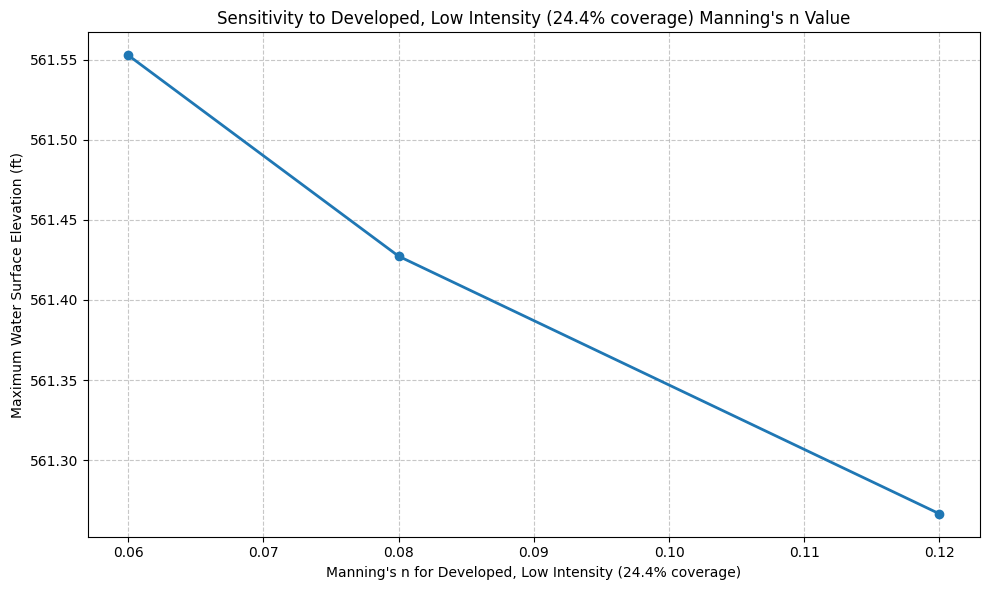

Created sensitivity plot for Developed, Low Intensity


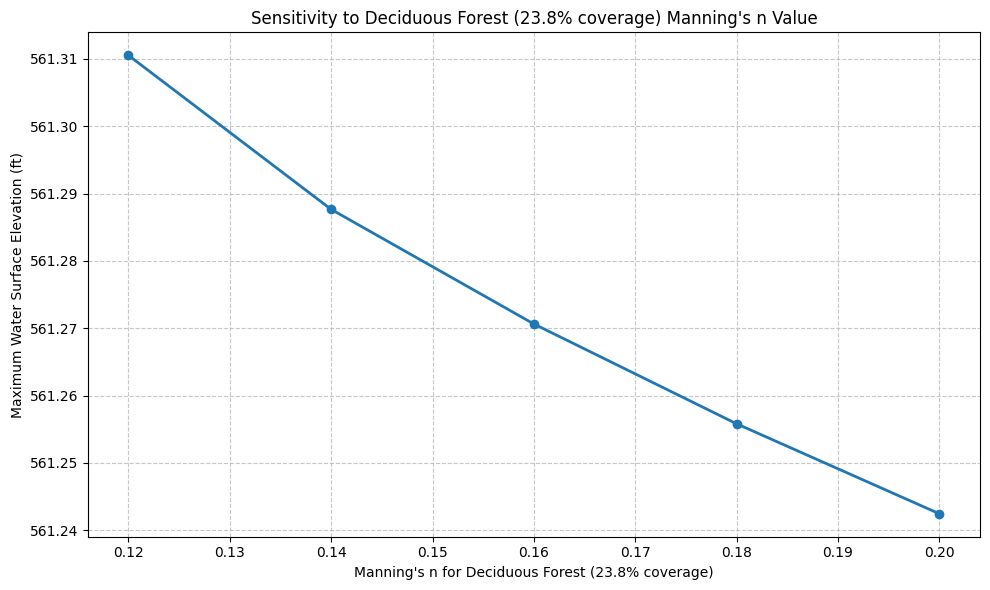

Created sensitivity plot for Deciduous Forest


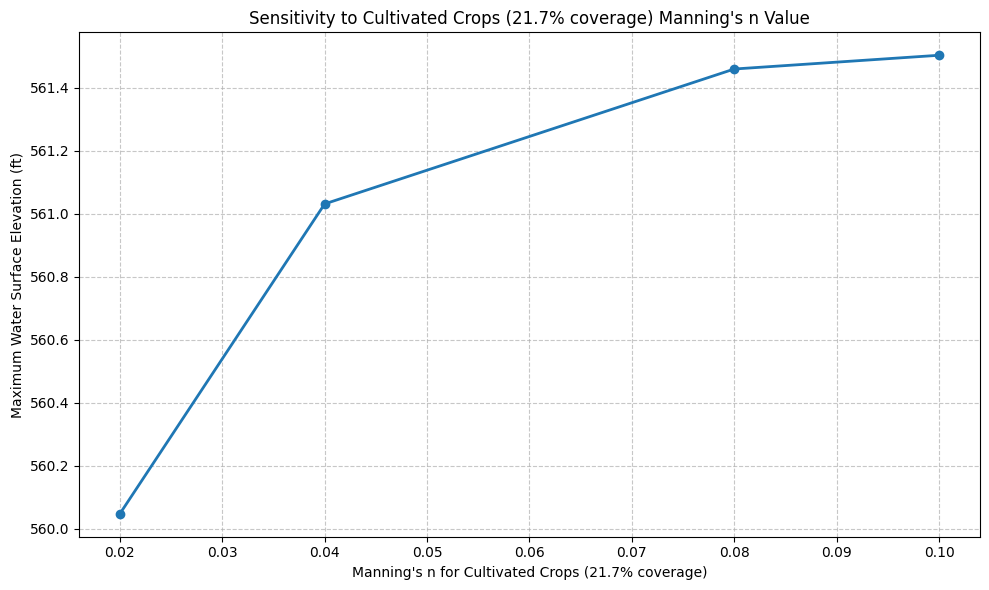

Created sensitivity plot for Cultivated Crops


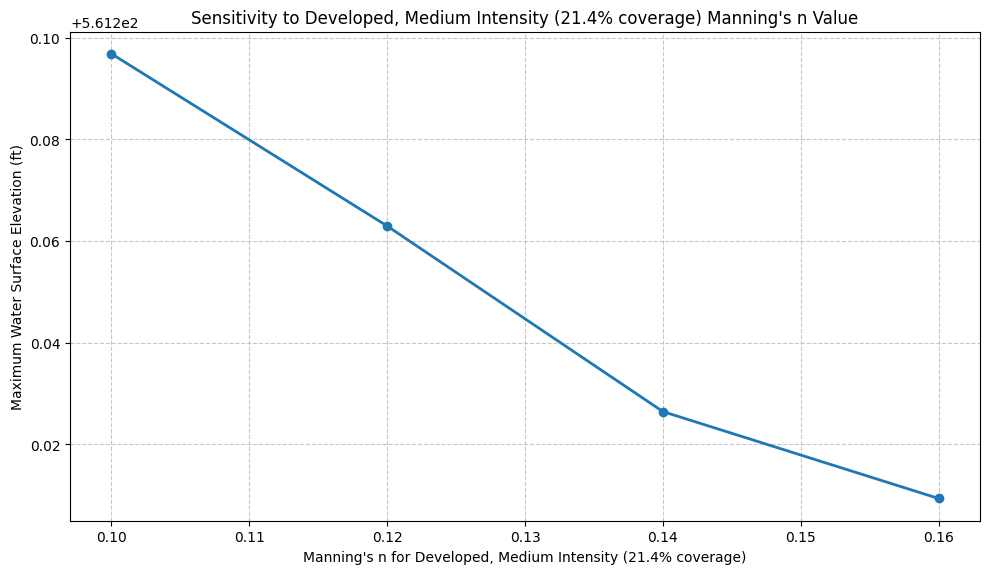

Created sensitivity plot for Developed, Medium Intensity


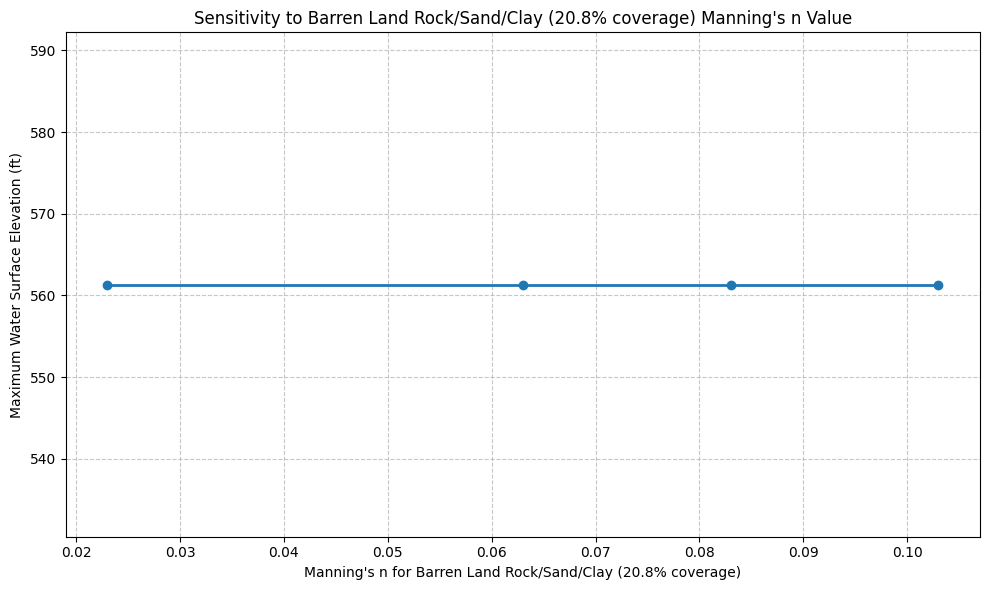

Created sensitivity plot for Barren Land Rock/Sand/Clay


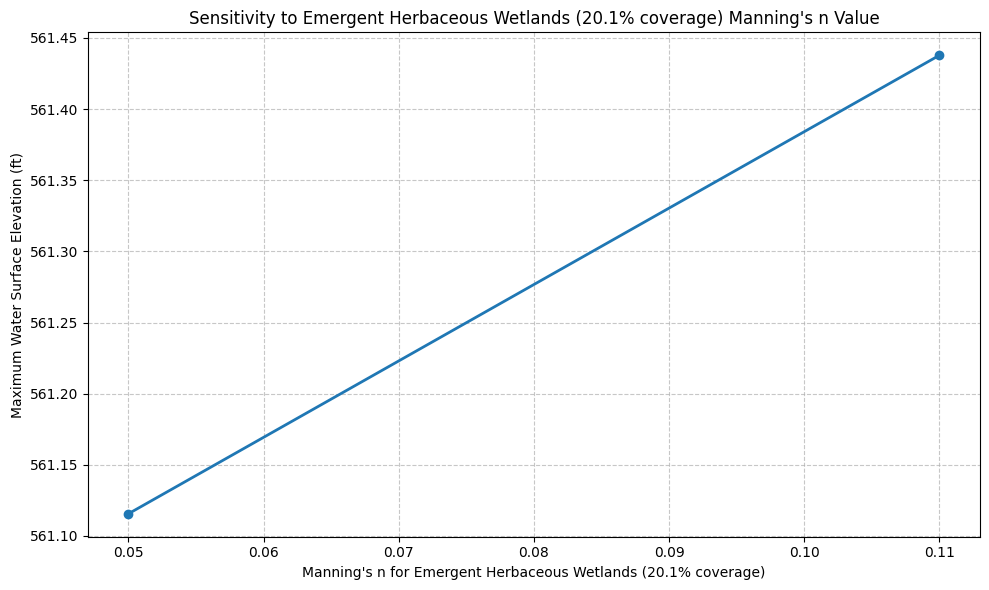

Created sensitivity plot for Emergent Herbaceous Wetlands


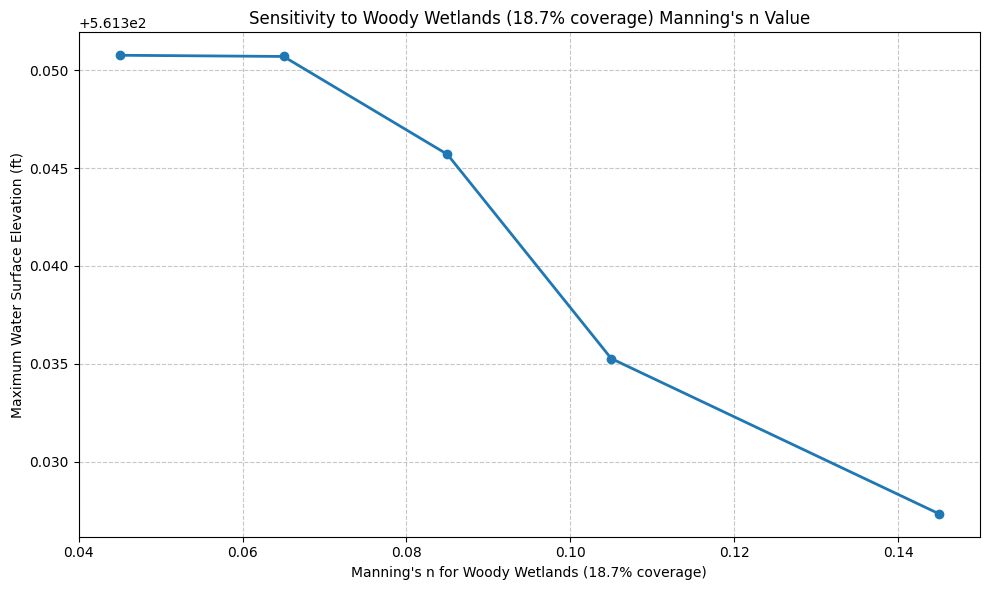

Created sensitivity plot for Woody Wetlands


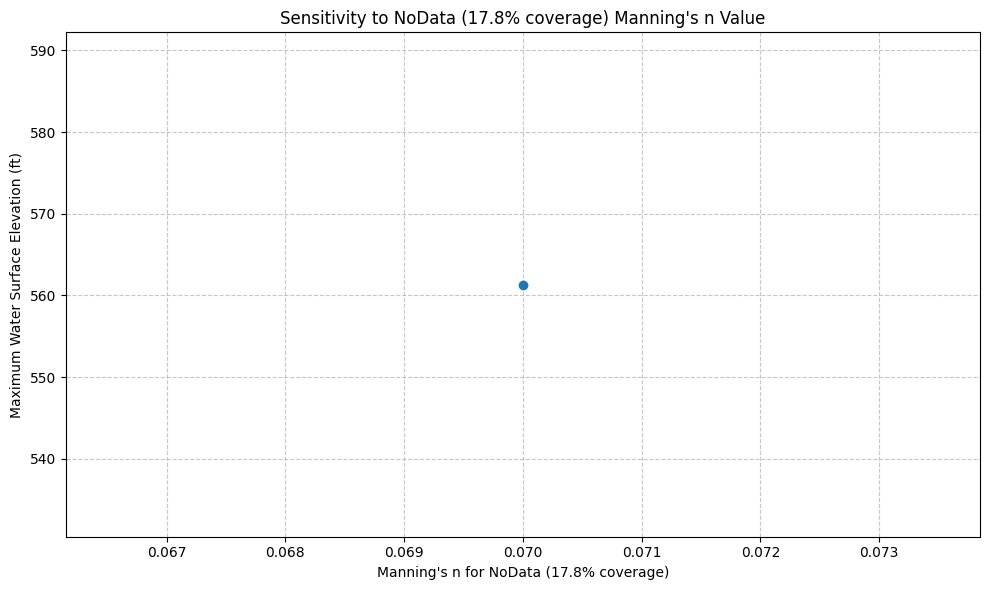

Created sensitivity plot for NoData


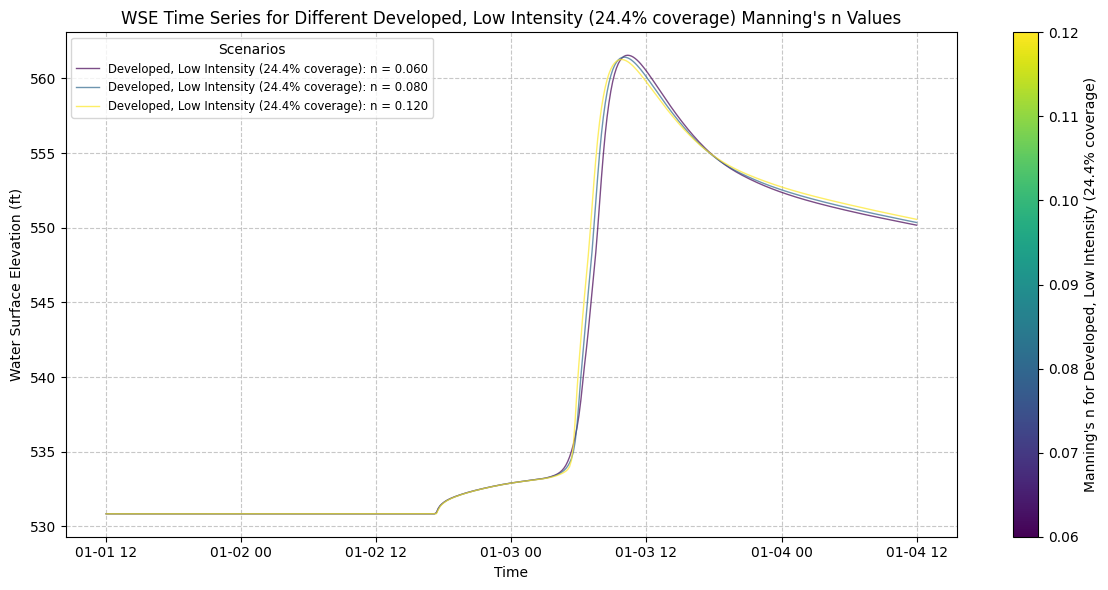

Created time series plot for Developed, Low Intensity


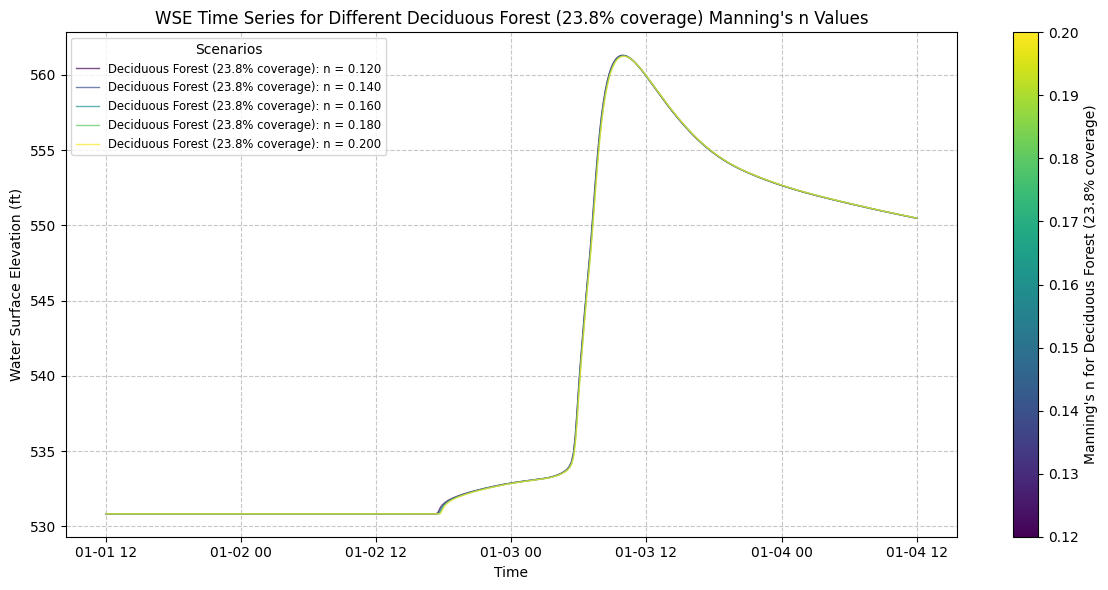

Created time series plot for Deciduous Forest


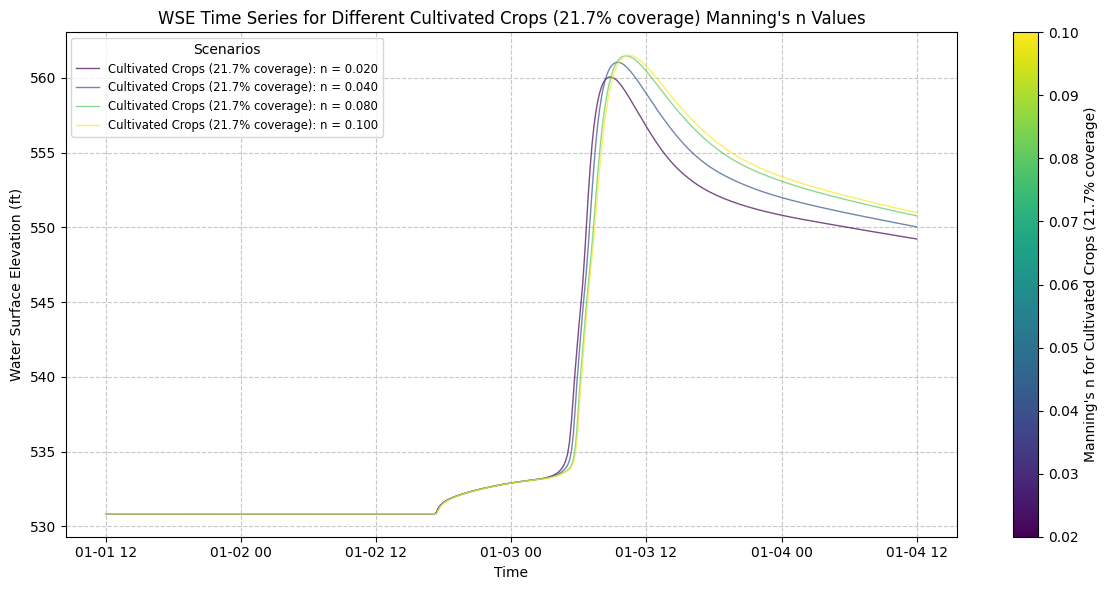

Created time series plot for Cultivated Crops


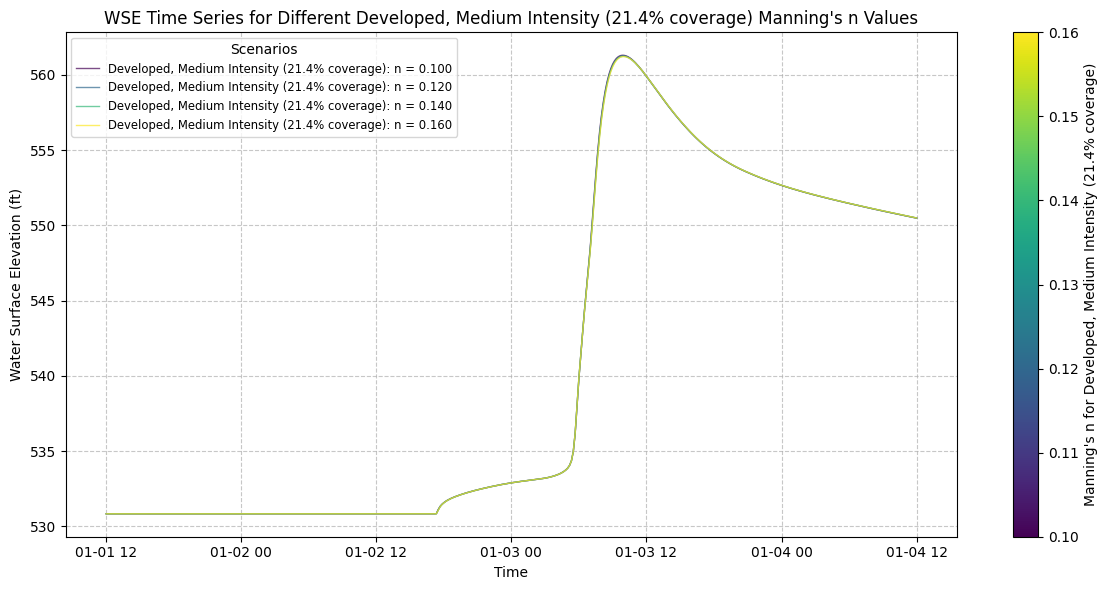

Created time series plot for Developed, Medium Intensity


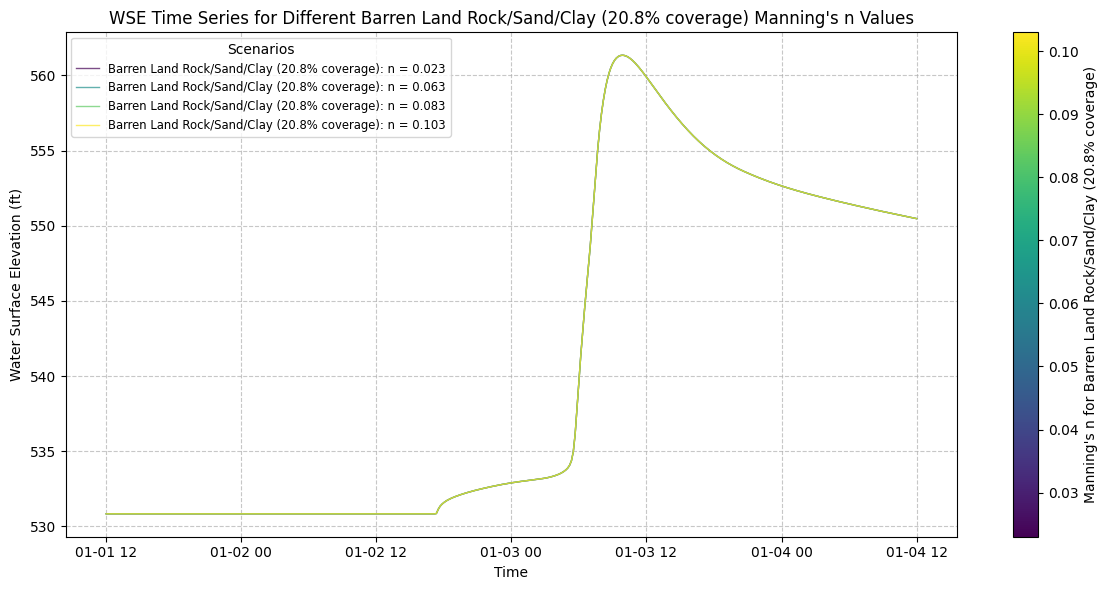

Created time series plot for Barren Land Rock/Sand/Clay


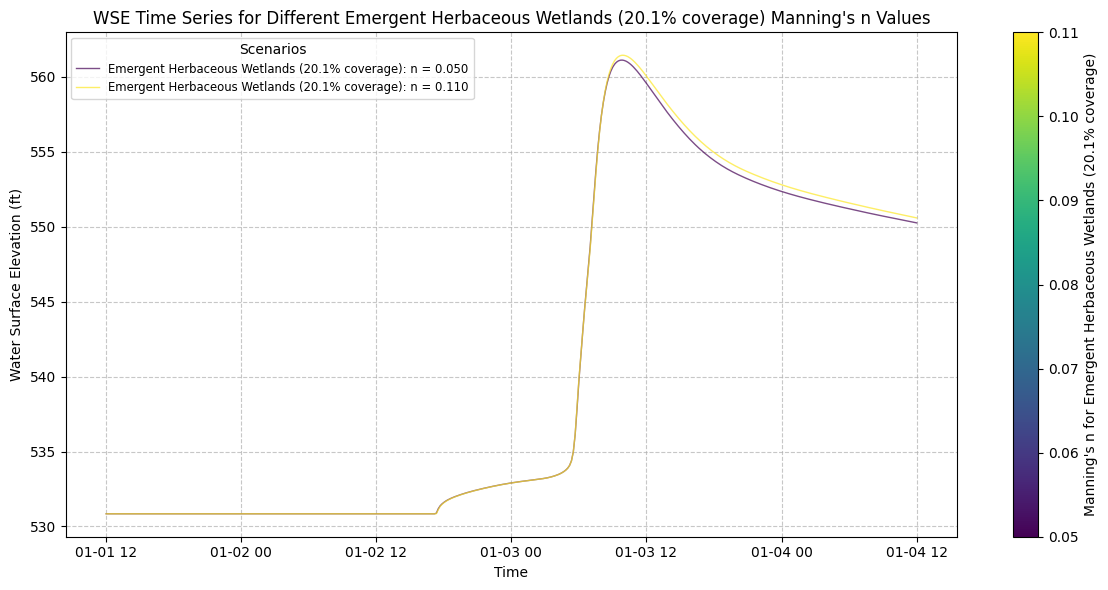

Created time series plot for Emergent Herbaceous Wetlands


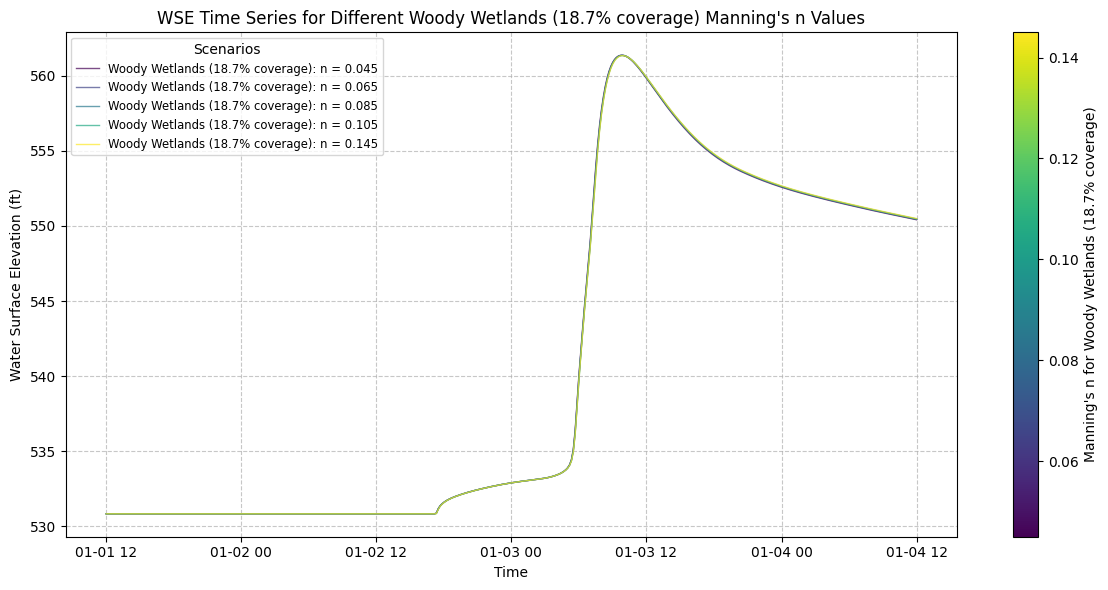

Created time series plot for Woody Wetlands


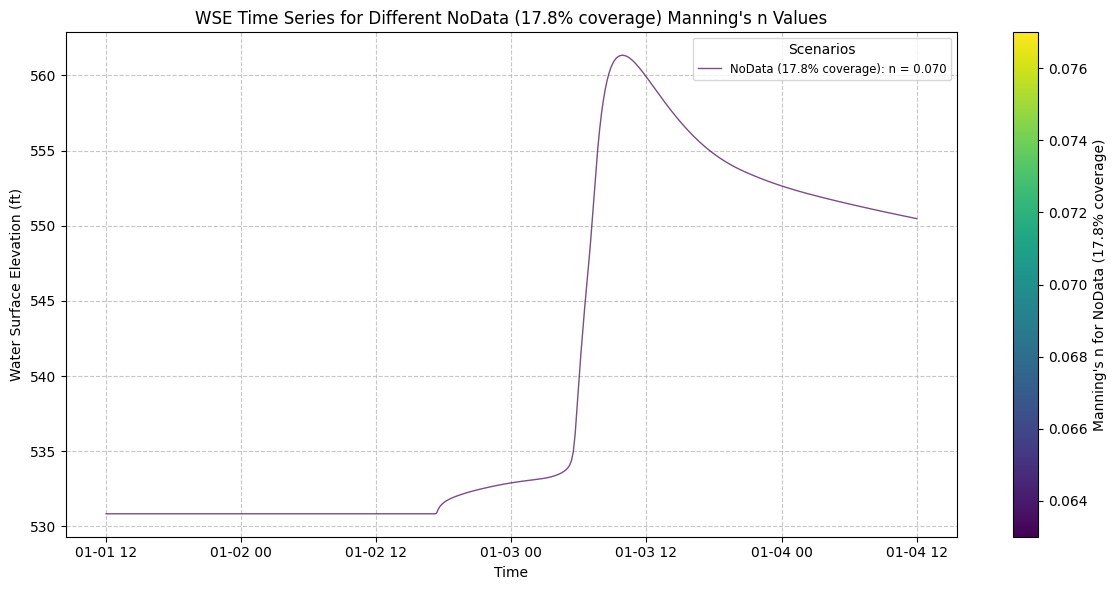

Created time series plot for NoData

Analysis complete! Results saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity

Significant land uses analyzed:
                Land Cover Type  Percentage
0      Developed, Low Intensity   24.351298
1              Deciduous Forest   23.788681
2              Cultivated Crops   21.742102
3   Developed, Medium Intensity   21.446019
4    Barren Land Rock/Sand/Clay   20.764913
5  Emergent Herbaceous Wetlands   20.132640
6                Woody Wetlands   18.749913
7                        NoData   17.777669


In [9]:

# Run the base sensitivity analysis
base_sensitivity_results = individual_landuse_sensitivity_base(
    project_folder=project_folder,
    template_plan=template_plan,
    point_of_interest=point_of_interest,
    area_threshold=15.0,  # Only analyze land uses covering at least 10% of the mesh area
    interval=0.02,       # Adjust interval to reduce the number of test values
    max_workers=4,
    num_cores=2,
    output_folder="Base_Landuse_Sensitivity",
    n_ranges=manning_minmax_df
)



# Print summary information
if base_sensitivity_results:
    print("\nAnalysis complete! Results saved to:", base_sensitivity_results['output_folder'])
    if 'significant_landuses' in base_sensitivity_results:
        print("\nSignificant land uses analyzed:")
        print(base_sensitivity_results['significant_landuses'][['Land Cover Type', 'Percentage']])



-----

## Base Override Sensitivity Results

### Interpreting the Results

The following plots show sensitivity analysis results from the BaldEagleCrkMulti2D example project (Plan 03):

**Sensitivity Plots (Right):**
- Show how maximum water surface elevation varies with Manning's n
- X-axis: Manning's n value for the specific land cover type
- Y-axis: Maximum water surface elevation at the point of interest
- Red dot: Current/template Manning's n value
- Steeper slopes indicate higher sensitivity to that parameter

**Time Series Plots (Left):**
- Show complete hydrographs for all Manning's n scenarios
- Color gradient represents different Manning's n values
- Black line: Template (original) scenario
- Useful for understanding how timing and peak magnitude respond to parameter changes

**Key Observations to Look For:**
- Which land covers cause the largest changes in water surface elevation?
- Are the responses linear or non-linear?
- Does increasing roughness always increase water levels (as expected)?
- Are there threshold effects or inflection points?


-----

# Part 3: Regional Override Sensitivity Analysis

## Overview

Regional override sensitivity analysis focuses on Manning's n variations within specific calibration regions of the model. This approach is appropriate when:
- Calibrating main channel roughness separately from floodplain
- Analyzing the impact of localized land cover changes
- Testing region-specific parameter uncertainty
- Evaluating different roughness values in distinct hydraulic zones

**Key Differences from Base Sensitivity:**
- Tests only land covers present in the specified region(s)
- Can target a single region or analyze all regions
- Useful for main channel calibration or localized sensitivity testing
- Regional overrides take precedence over base mesh values in HEC-RAS

## Function: individual_landuse_sensitivity_region()

This function performs the complete regional override sensitivity workflow with region-specific filtering.

In [10]:
def individual_landuse_sensitivity_region(
    project_folder,
    template_plan,
    point_of_interest,
    area_threshold=10.0,  # percentage threshold for significant land uses
    interval=0.01,
    max_workers=2,
    num_cores=2,
    region_name=None,  # optional specific region to analyze
    output_folder="Regional_Landuse_Sensitivity",
    n_ranges=None
):
    """
    Perform sensitivity analysis by varying individual land use Manning's n values
    in the regional overrides.
    
    Args:
        project_folder (str): Path to HEC-RAS project folder
        template_plan (str): Plan number to use as template
        point_of_interest (tuple or Point): Coordinates for extracting results
        area_threshold (float): Percentage threshold for significant land uses
        interval (float): Interval for Manning's n test values
        max_workers (int): Number of parallel workers
        num_cores (int): Number of cores per worker
        region_name (str): Optional specific region to analyze
        output_folder (str): Name of output folder
        n_ranges (pd.DataFrame): DataFrame containing min/max Manning's n values.
                                    Must contain columns: 'Land Cover Name', 'min_n', 'max_n'
    
    Returns:
        dict: Results of sensitivity analysis
    """
    import time
    from datetime import datetime
    
    # Convert point_of_interest to Point if not already
    if not isinstance(point_of_interest, Point):
        point_of_interest = Point(point_of_interest[0], point_of_interest[1])
    
    # Verify n_ranges is provided
    if n_ranges is None:
        raise ValueError("n_ranges DataFrame must be provided")
    
    # Create timestamp for unique run identifier
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Initialize RAS project
    print(f"Initializing HEC-RAS project: {project_folder}")
    ras = init_ras_project(project_folder, "6.6")
    
    # Create output directory
    results_dir = Path(project_folder) / output_folder
    results_dir.mkdir(exist_ok=True)
    print(f"Results will be saved to: {results_dir}")
    
    # Verify template plan exists
    if template_plan not in ras.plan_df['plan_number'].values:
        raise ValueError(f"Template plan {template_plan} not found in project")
    
    # Get the geometry number for the template plan
    template_geom = ras.plan_df.loc[ras.plan_df['plan_number'] == template_plan, 'geometry_number'].values[0]
    print(f"\nTemplate plan: {template_plan} (Geometry: {template_geom})")
    
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'full_path'].values[0]
    
    # Get the original Manning's values
    original_baseoverrides = RasGeo.get_mannings_baseoverrides(geom_path)
    original_regionoverrides = RasGeo.get_mannings_regionoverrides(geom_path)
    
    # Check if regional overrides exist
    if original_regionoverrides.empty:
        print("No regional Manning's overrides found in the model")
        return None
    
    # If a specific region name is provided, filter the regional overrides
    if region_name is not None:
        region_mask = original_regionoverrides['Region Name'] == region_name
        if not region_mask.any():
            print(f"Region '{region_name}' not found in the model")
            available_regions = original_regionoverrides['Region Name'].unique()
            print(f"Available regions: {available_regions}")
            return None
        
        region_overrides = original_regionoverrides[region_mask].copy()
        print(f"\nAnalyzing sensitivity for region: {region_name}")
    else:
        region_overrides = original_regionoverrides.copy()
        print("\nAnalyzing sensitivity for all regions")
    
    # Get unique region tables
    region_tables = region_overrides['Table Number'].unique()
    print(f"Region tables: {region_tables}")
    
    # Analyze land cover statistics for the 2D mesh areas
    print("\nAnalyzing land cover statistics for the 2D mesh areas...")
    landcover_stats = analyze_mesh_land_cover_statistics(
        project_folder, 
        geom_number=template_geom
    )
    
    if landcover_stats is None:
        raise ValueError("Could not analyze land cover statistics")
    
    # Identify significant land uses (above threshold)
    significant_landuses = landcover_stats[landcover_stats['Percentage'] >= area_threshold].copy()
    significant_landuses = significant_landuses.sort_values('Percentage', ascending=False).reset_index(drop=True)
    
    if len(significant_landuses) == 0:
        print(f"No land uses found with coverage above {area_threshold}% threshold")
        return None
    
    print(f"\nFound {len(significant_landuses)} significant land uses (>= {area_threshold}% coverage):")
    print(significant_landuses[['Land Cover Type', 'Percentage', 'Current_n']])
    
    # Filter significant land uses to only those present in the region overrides
    region_landcover_types = set(region_overrides['Land Cover Name'].unique())
    filtered_landuses = significant_landuses[
        significant_landuses['Land Cover Type'].isin(region_landcover_types)
    ].copy()
    
    if len(filtered_landuses) == 0:
        print("None of the significant land uses are present in the regional overrides")
        return None
    
    print(f"\nSignificant land uses present in regional overrides:")
    print(filtered_landuses[['Land Cover Type', 'Percentage']])
    
    # Check if we'll exceed the plan limit
    current_plan_count = len(ras.plan_df)
    max_plans = 99  # HEC-RAS limit
    remaining_plans = max_plans - current_plan_count
    
    # Estimate the number of plans needed
    estimated_plan_count = 0
    
    # Create a table to store land use sensitivity information
    sensitivity_table = []
    
    for _, landuse in filtered_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        
        # Find this land cover in the region overrides
        for region_table in region_tables:
            # Create mask for this land cover and table
            mask = (region_overrides['Land Cover Name'] == land_cover) & \
                   (region_overrides['Table Number'] == region_table)
            
            if not mask.any():
                continue
                
            current_n = region_overrides.loc[mask, 'MainChannel'].values[0]
            
            # Find matching land cover in n_ranges
            match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
            if match.empty:
                continue
                
            min_n = match['min_n'].values[0]
            max_n = match['max_n'].values[0]
            
            # Count values between min and max at interval spacing, excluding current value
            values = generate_sensitivity_values(min_n, max_n, current_n, interval)
            num_values = len(values)
            estimated_plan_count += num_values
            
            # Add to sensitivity table
            region_name = region_overrides.loc[mask, 'Region Name'].values[0] if 'Region Name' in region_overrides.columns else f"Table {region_table}"
            sensitivity_table.append({
                'Land Cover': land_cover,
                'Region': region_name,
                'Table': region_table,
                'Current n': current_n,
                'Min n': min_n,
                'Max n': max_n,
                'Test Values': num_values,
                'n Range': f"{min_n:.3f} - {max_n:.3f}"
            })
    
    # Print the sensitivity analysis table
    if sensitivity_table:
        print("\nSensitivity Analysis Plan:")
        print("-" * 80)
        print(f"{'Land Cover':<20} {'Region':<15} {'Current n':<10} {'n Range':<15} {'Test Values':<12}")
        print("-" * 80)
        for row in sensitivity_table:
            print(f"{row['Land Cover']:<20} {row['Region']:<15} {row['Current n']:<10.3f} {row['n Range']:<15} {row['Test Values']:<12}")
        print("-" * 80)
        print(f"Total estimated plans to be created: {estimated_plan_count}")
        print("-" * 80)
    if estimated_plan_count > remaining_plans:
        print(f"\nWARNING: This analysis would create approximately {estimated_plan_count} plans, but only {remaining_plans} more plans can be added (limit is 99)")
        print("Consider adjusting the following to reduce the number of plans:")
        print(f"1. Increase the area threshold (currently {area_threshold}%)")
        print(f"2. Increase the interval between test values (currently {interval})")
        print(f"3. Reduce the min/max ranges for land uses")
        print(f"4. Select fewer land uses to test")
        print(f"5. Specify a single region to test (currently {'specific region' if region_name else 'all regions'})")
        
        # Ask for confirmation to continue
        response = input("\nDo you want to continue anyway? (y/n): ")
        if response.lower() != 'y':
            print("Analysis canceled")
            return None
    
    # Store the current (template) plan as base scenario
    scenarios = [{
        'name': 'Template',
        'plan_number': template_plan,
        'geom_number': template_geom,
        'shortid': 'Template',
        'land_cover': None,
        'region_name': None,
        'table_number': None,
        'n_value': None,
        'description': "Original Manning's n Values"
    }]
    
    # Function to create a modified plan with adjusted Manning's n values for a specific land use in a region
    def create_modified_plan(land_cover, table_number, region_name, new_n_value):
        # Create a shortid based on land cover, region, and n value
        # Convert land cover name to code (e.g. "Open Water" -> "OW")
        lc_code = ''.join([word[0] for word in land_cover.split() if word[0].isalpha()])
        if not lc_code:
            lc_code = land_cover[:2]
        lc_code = lc_code.upper()
        
        # Convert region name to code
        rg_code = ''.join([word[0] for word in region_name.split() if word[0].isalpha()])
        if not rg_code:
            rg_code = region_name[:2]
        rg_code = rg_code.upper()
        
        # Format n value for shortid
        n_str = f"{new_n_value:.3f}".replace(".", "")
        shortid = f"R_{lc_code}_{rg_code}_{n_str}"
        
        print(f"\nCreating plan for '{land_cover}' in '{region_name}' with n = {new_n_value} (ShortID: {shortid})")
        
        # Clone the template plan
        new_plan_number = RasPlan.clone_plan(template_plan, new_plan_shortid=shortid)
        
        # Clone the template geometry
        new_geom_number = RasPlan.clone_geom(template_geom)
        
        # Set the new plan to use the new geometry
        RasPlan.set_geom(new_plan_number, new_geom_number)
        
        # Get the new geometry file path
        new_geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == new_geom_number, 'full_path'].values[0]
        
        # Copy base overrides unchanged
        RasGeo.set_mannings_baseoverrides(new_geom_path, original_baseoverrides)
        
        # Create modified region overrides
        modified_regionoverrides = original_regionoverrides.copy()
        
        # Update the Manning's n value for this specific land cover type in this region and table
        region_mask = (modified_regionoverrides['Land Cover Name'] == land_cover) & \
                     (modified_regionoverrides['Table Number'] == table_number) & \
                     (modified_regionoverrides['Region Name'] == region_name)
                     
        if region_mask.any():
            current_n = modified_regionoverrides.loc[region_mask, 'MainChannel'].values[0]
            print(f"  Changing '{land_cover}' in '{region_name}' (Table {table_number}) from {current_n:.4f} to {new_n_value:.4f}")
            modified_regionoverrides.loc[region_mask, 'MainChannel'] = new_n_value
        else:
            print(f"  Warning: Land cover '{land_cover}' not found in region '{region_name}' (Table {table_number})")
        
        # Apply the modified region overrides
        RasGeo.set_mannings_regionoverrides(new_geom_path, modified_regionoverrides)
        
        # Store scenario details
        return {
            'name': f"{land_cover}_{region_name}_{new_n_value:.3f}",
            'plan_number': new_plan_number,
            'geom_number': new_geom_number,
            'shortid': shortid,
            'land_cover': land_cover,
            'region_name': region_name,
            'table_number': table_number,
            'n_value': new_n_value,
            'description': f"Manning's n = {new_n_value:.3f} for {land_cover} in {region_name}"
        }
    
    # Create plans for each significant land use with varying n values
    all_plans_to_run = []
    
    for _, landuse in filtered_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        
        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
        
        if match.empty:
            print(f"Warning: No Manning's n range found for '{land_cover}'. Skipping.")
            continue
            
        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]
        
        # Process each region table for this land cover
        for region_table in region_tables:
            # Get all regions with this land cover in this table
            regions_mask = (region_overrides['Land Cover Name'] == land_cover) & \
                          (region_overrides['Table Number'] == region_table)
            
            if not regions_mask.any():
                continue
            
            # Get unique region names for this land cover and table
            unique_regions = region_overrides.loc[regions_mask, 'Region Name'].unique()
            
            for region in unique_regions:
                # If a specific region was requested, skip others
                if region_name is not None and region != region_name:
                    continue
                
                # Create mask for this specific combination
                specific_mask = (region_overrides['Land Cover Name'] == land_cover) & \
                               (region_overrides['Table Number'] == region_table) & \
                               (region_overrides['Region Name'] == region)
                
                if not specific_mask.any():
                    continue
                
                current_n = region_overrides.loc[specific_mask, 'MainChannel'].values[0]
                
                print(f"\nProcessing land cover: {land_cover} in region: {region} (Table {region_table})")
                print(f"  Current n: {current_n:.4f}")
                print(f"  Literature range: {min_n:.4f} to {max_n:.4f}")
                
                # Generate test values within the range, excluding the current value
                test_values = generate_sensitivity_values(min_n, max_n, current_n, interval)
                
                print(f"  Testing {len(test_values)} values: {[round(val, 3) for val in test_values]}")
                
                # Create a plan for each test value
                for n_value in test_values:
                    new_scenario = create_modified_plan(land_cover, region_table, region, n_value)
                    scenarios.append(new_scenario)
                    all_plans_to_run.append(new_scenario['plan_number'])
    
    # Save scenario information
    scenario_info = pd.DataFrame(scenarios)
    scenario_info_path = results_dir / "scenarios.csv"
    scenario_info.to_csv(scenario_info_path, index=False)
    print(f"\nScenario information saved to: {scenario_info_path}")
    
    # Run the plans (excluding the template which is already computed)
    plans_to_run = [plan for plan in all_plans_to_run if plan != template_plan]
    
    if not plans_to_run:
        print("No plans to run.")
        return {'scenarios': scenarios, 'output_folder': results_dir}
    
    print(f"\nRunning {len(plans_to_run)} plans in parallel...")
    execution_results = RasCmdr.compute_parallel(
        plan_number=plans_to_run,
        max_workers=max_workers,
        num_cores=num_cores,
        clear_geompre=True
    )
    
    print("\nExecution results:")
    for plan, success in execution_results.items():
        print(f"  Plan {plan}: {'Successful' if success else 'Failed'}")
    
    # If point of interest provided, extract and compare results
    if point_of_interest is not None:
        # Get geometry HDF path for cell identification
        geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'hdf_path'].values[0]
        
        # Find the nearest mesh cell
        mesh_cells_gdf = HdfMesh.get_mesh_cell_points(geom_hdf_path)
        distances = mesh_cells_gdf.geometry.apply(lambda geom: geom.distance(point_of_interest))
        nearest_idx = distances.idxmin()
        mesh_cell_id = mesh_cells_gdf.loc[nearest_idx, 'cell_id']
        mesh_name = mesh_cells_gdf.loc[nearest_idx, 'mesh_name']
        
        print(f"\nNearest cell ID: {mesh_cell_id}")
        print(f"Distance: {distances[nearest_idx]:.2f} units")
        print(f"Mesh area: {mesh_name}")
        
        # Extract results for each scenario
        all_results = {}
        max_ws_values = []
        
        for scenario in scenarios:
            plan_number = scenario['plan_number']
            land_cover = scenario['land_cover']
            region_name = scenario['region_name']
            n_value = scenario['n_value']
            shortid = scenario['shortid']
            
            try:
                results_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_number)
                
                # Extract water surface data
                ws_data = results_xr[mesh_name]['Water Surface'].sel(cell_id=int(mesh_cell_id))
                
                # Convert to DataFrame
                ws_df = pd.DataFrame({
                    'time': ws_data.time.values,
                    'water_surface': ws_data.values
                })
                
                # Store results
                max_ws = ws_df['water_surface'].max()
                
                all_results[plan_number] = {
                    'scenario': scenario,
                    'df': ws_df,
                    'max_water_surface': max_ws
                }
                
                max_ws_values.append({
                    'plan_number': plan_number,
                    'shortid': shortid,
                    'land_cover': land_cover,
                    'region_name': region_name,
                    'n_value': n_value,
                    'max_water_surface': max_ws
                })
                
                print(f"  {shortid}: Max WSE = {max_ws:.2f}")
                
                # Save time series to CSV
                ws_df.to_csv(results_dir / f"timeseries_{shortid}.csv", index=False)
                
            except Exception as e:
                print(f"  Error extracting results for {shortid}: {str(e)}")
        
        # Create summary DataFrame
        if max_ws_values:
            max_ws_df = pd.DataFrame(max_ws_values)
            max_ws_df.to_csv(results_dir / "max_water_surface_summary.csv", index=False)
            
            # Create plots by land cover type and region
            land_cover_region_combinations = []
            
            for _, row in max_ws_df.iterrows():
                if row['land_cover'] is not None and row['region_name'] is not None:
                    combination = (row['land_cover'], row['region_name'])
                    if combination not in land_cover_region_combinations:
                        land_cover_region_combinations.append(combination)
            
            # Create sensitivity plots for each land cover + region combination
            for land_cover, region in land_cover_region_combinations:
                # Filter scenarios for this combination
                combo_scenarios = max_ws_df[
                    (max_ws_df['land_cover'] == land_cover) & 
                    (max_ws_df['region_name'] == region)
                ].copy()
                
                # Add the template scenario
                template_row = max_ws_df[max_ws_df['shortid'] == 'Template']
                if not template_row.empty:
                    combo_scenarios = pd.concat([template_row, combo_scenarios])
                
                if combo_scenarios.empty:
                    continue
                
                # Sort by n_value
                combo_scenarios = combo_scenarios.sort_values('n_value').reset_index(drop=True)
                
                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(combo_scenarios['n_value'], combo_scenarios['max_water_surface'], 
                         marker='o', linestyle='-', linewidth=2)
                
                # Add template point in a different color if it exists
                template_idx = combo_scenarios[combo_scenarios['shortid'] == 'Template'].index
                if not template_idx.empty:
                    ax.scatter(combo_scenarios.loc[template_idx, 'n_value'], 
                                combo_scenarios.loc[template_idx, 'max_water_surface'],
                                color='red', s=100, zorder=5, label='Template')
                
                # Add labels and title
                ax.set_xlabel(f"Manning's n for {land_cover} in {region}")
                ax.set_ylabel("Maximum Water Surface Elevation (ft)")
                ax.set_title(f"Sensitivity to {land_cover} Manning's n Value in {region}")
                ax.grid(True, linestyle='--', alpha=0.7)
                
                if not template_idx.empty:
                    ax.legend()
                
                # Save plot
                safe_lc = land_cover.replace(' ', '_').replace('/', '_')
                safe_rg = region.replace(' ', '_').replace('/', '_')
                plot_path = results_dir / f"sensitivity_{safe_lc}_{safe_rg}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created sensitivity plot for {land_cover} in {region}")
            
            # Create time series comparison plots for each land cover + region combination
            for land_cover, region in land_cover_region_combinations:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                # Get template results
                template_plan = scenarios[0]['plan_number']
                if template_plan in all_results:
                    template_df = all_results[template_plan]['df']
                    ax.plot(template_df['time'], template_df['water_surface'], 
                             color='black', linewidth=2, label='Template')
                
                # Filter scenarios for this combination
                combo_scenarios = [
                    s for s in scenarios 
                    if s['land_cover'] == land_cover and s['region_name'] == region
                ]
                
                if not combo_scenarios:
                    plt.show()
                    plt.close()
                    continue
                
                # Setup colormap for n values
                n_values = [s['n_value'] for s in combo_scenarios if s['n_value'] is not None]
                if not n_values:
                    plt.show()
                    plt.close()
                    continue
                    
                min_n = min(n_values)
                max_n = max(n_values)
                norm = plt.Normalize(min_n, max_n)
                cmap = plt.cm.viridis
                
                # Plot each scenario
                for scenario in combo_scenarios:
                    plan_number = scenario['plan_number']
                    n_value = scenario['n_value']
                    
                    if plan_number in all_results and n_value is not None:
                        df = all_results[plan_number]['df']
                        color = cmap(norm(n_value))
                        ax.plot(df['time'], df['water_surface'], color=color, 
                                 linewidth=1, alpha=0.7, label=f"n = {n_value:.3f}")
                
                # Add labels and title
                ax.set_xlabel("Time")
                ax.set_ylabel("Water Surface Elevation (ft)")
                ax.set_title(f"WSE Time Series for {land_cover} in {region}")
                ax.grid(True, linestyle='--', alpha=0.7)
                
                # Add colorbar
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label(f"Manning's n for {land_cover}")
                
                # Save plot
                safe_lc = land_cover.replace(' ', '_').replace('/', '_')
                safe_rg = region.replace(' ', '_').replace('/', '_')
                plot_path = results_dir / f"timeseries_{safe_lc}_{safe_rg}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created time series plot for {land_cover} in {region}")
    
    # Return results
    return {
        'scenarios': scenarios,
        'execution_results': execution_results if 'execution_results' in locals() else None,
        'results': all_results if 'all_results' in locals() else None,
        'max_ws_summary': max_ws_df if 'max_ws_df' in locals() else None,
        'significant_landuses': filtered_landuses,
        'output_folder': results_dir
    }

-----

-----

## ⚠️ Important Engineering Note on Regional Overrides

We are using a HEC Example project with regional overriddes in the main channel.  A better application would be to vary values individually within larger calibration regions.  A further explanation follows: 

**Main Channel vs. Floodplain Application:**

For **main channel** regional overrides, a **bulk sensitivity approach** is typically more appropriate (see notebook 105 for bulk Manning's n variation). This is because:

1. **Land use-based roughness** values are derived from satellite imagery, which may not correlate well with main channel hydraulic roughness
2. **Main channel roughness** is typically governed by bed material, channel shape, and vegetation conditions—not upland land cover classifications
3. **Bulk variation** allows testing a continuous range of main channel n values without land use constraints

**This Methodology Best Applied To:**
- Large calibration regions within the 2D mesh area
- Floodplain zones with distinct land cover characteristics
- Areas where satellite-derived land use correlates with hydraulic roughness

**For Main Channel Calibration:**
- Use the bulk sensitivity approach from notebook 105
- Create multiple regional overrides to test different main channel reaches independently
- Consider physical channel characteristics rather than land cover when selecting test values

**Note on Example Project:**
This notebook demonstrates the regional sensitivity methodology using the BaldEagleCrkMulti2D main channel region due to limited availability of example models with large floodplain calibration regions. In practice, apply this approach to appropriate floodplain or mesh regions where land cover-based roughness is hydraulically meaningful.

## Executing Regional Override Sensitivity Analysis

### Configuration Parameters

The following example demonstrates how to run the regional override sensitivity analysis with the BaldEagleCrkMulti2D sample project.

**Key Parameters (in addition to base parameters):**
- `region_name`: Specific region to analyze (e.g., "Main Channel"), or `None` to analyze all regions
- All other parameters match the base sensitivity function

**Region-Specific Behavior:**
- Only land covers present in the specified region(s) will be tested
- The function automatically filters significant land uses based on region membership
- Multiple regions with the same land cover will be tested independently

### Execution Steps

1. Use the same project from the base analysis (already extracted)
2. Configure regional analysis parameters (note the `region_name` parameter)
3. Run the sensitivity analysis
4. Review region-specific results in the output folder


In [11]:
# Define the mannings n max and min values as a range. 

manning_data = [
    {"Land Cover Name": "NoData", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Barren Land Rock/Sand/Clay", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Cultivated Crops", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Deciduous Forest", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Developed, High Intensity", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Developed, Low Intensity", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Developed, Medium Intensity", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Developed, Open Space", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Emergent Herbaceous Wetlands", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Evergreen Forest", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Grassland/Herbaceous", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Mixed Forest", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Open Water", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Pasture/Hay", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Shrub/Scrub", "min_n": 0.03, "max_n": 0.23},
    {"Land Cover Name": "Woody Wetlands", "min_n": 0.03, "max_n": 0.23}
]

# Create DataFrame
manning_minmax_df = pd.DataFrame(manning_data)

# Calculate the midpoint value
manning_minmax_df['mid_n'] = (manning_minmax_df['min_n'] + manning_minmax_df['max_n']) / 2

# Sort by land cover name
manning_minmax_df = manning_minmax_df.sort_values('Land Cover Name').reset_index(drop=True)

# Print summary information
print(f"Manning's n value ranges for {len(manning_minmax_df)} land cover types:")
print(manning_minmax_df)

Manning's n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n  mid_n
0     Barren Land Rock/Sand/Clay   0.03   0.23   0.13
1               Cultivated Crops   0.03   0.23   0.13
2               Deciduous Forest   0.03   0.23   0.13
3      Developed, High Intensity   0.03   0.23   0.13
4       Developed, Low Intensity   0.03   0.23   0.13
5    Developed, Medium Intensity   0.03   0.23   0.13
6          Developed, Open Space   0.03   0.23   0.13
7   Emergent Herbaceous Wetlands   0.03   0.23   0.13
8               Evergreen Forest   0.03   0.23   0.13
9           Grassland/Herbaceous   0.03   0.23   0.13
10                  Mixed Forest   0.03   0.23   0.13
11                        NoData   0.03   0.23   0.13
12                    Open Water   0.03   0.23   0.13
13                   Pasture/Hay   0.03   0.23   0.13
14                   Shrub/Scrub   0.03   0.23   0.13
15                Woody Wetlands   0.03   0.23   0.13


Creating dedicated ROMIS project folder...


2025-11-22 07:45:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:14 - ras_commander.HdfMesh - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf
2025-11-22 07:45:14 - ras_commander.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf
2025-11-22 07:45:14 - ras_commander.HdfMesh - INFO - Using existing Path object HDF fi

Created: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS
Initializing HEC-RAS project: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS
Results will be saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\Regional_Landuse_Sensitivity

Template plan: 03 (Geometry: 09)

Analyzing sensitivity for region: Main Channel
Region tables: ['16']

Analyzing land cover statistics for the 2D mesh areas...
Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis
Analyzing land cover for mesh area: BaldEagleCr

Found 10 significant land uses (>= 10.0% coverage):
                Land Cover Type  Percentage  Current_n
0      Developed, Low Intensity   24.351298       0.10
1              Deciduous Forest   23.788681       0.10
2              Cultivated Crops   21.742102       0.06
3   Developed, Medium Intensity   21.446019       0.08
4    Barren Land Rock/Sand/Clay   20.764913       0.0

2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p07
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p07
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07
2025-11-22 07:45:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g04
2025-11-22 07:45:14 - ras_com

  Changing 'Developed, Low Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Developed, Low Intensity' in 'Main Channel' with n = 0.11 (ShortID: R_DLI_MC_0110)
  Changing 'Developed, Low Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Developed, Low Intensity' in 'Main Channel' with n = 0.15 (ShortID: R_DLI_MC_0150)


2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g07
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g07.hdf
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 07
2025-11-22 07:45:14 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g07 for plan 09
2025-11-22 07:45:14 - ras_commander.RasPlan - INFO - Geometry for plan 09 set to 07
2025-11-22 07:45:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\exam

  Changing 'Developed, Low Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Developed, Low Intensity' in 'Main Channel' with n = 0.19 (ShortID: R_DLI_MC_0190)
  Changing 'Developed, Low Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Developed, Low Intensity' in 'Main Channel' with n = 0.23 (ShortID: R_DLI_MC_0230)


2025-11-22 07:45:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g15
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g15.hdf
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 15
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g15 for plan 11
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Geometry for plan 11 set to 15
2025-11

  Changing 'Developed, Low Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Deciduous Forest in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Deciduous Forest' in 'Main Channel' with n = 0.07 (ShortID: R_DF_MC_0070)
  Changing 'Deciduous Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Deciduous Forest' in 'Main Channel' with n = 0.11 (ShortID: R_DF_MC_0110)


2025-11-22 07:45:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g17
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g17.hdf
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 17
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g17 for plan 14
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Geometry for plan 14 set to 17
2025-11

  Changing 'Deciduous Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Deciduous Forest' in 'Main Channel' with n = 0.15 (ShortID: R_DF_MC_0150)
  Changing 'Deciduous Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Deciduous Forest' in 'Main Channel' with n = 0.19 (ShortID: R_DF_MC_0190)


2025-11-22 07:45:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g19
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g19.hdf
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 19
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g19 for plan 20
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Geometry for plan 20 set to 19
2025-11

  Changing 'Deciduous Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Deciduous Forest' in 'Main Channel' with n = 0.23 (ShortID: R_DF_MC_0230)
  Changing 'Deciduous Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Cultivated Crops in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Cultivated Crops' in 'Main Channel' with n = 0.07 (ShortID: R_CC_MC_0070)


2025-11-22 07:45:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g21
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g21.hdf
2025-11-22 07:45:15 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 21
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g21 for plan 22
2025-11-22 07:45:15 - ras_commander.RasPlan - INFO - Geometry for plan 22 set to 21
2025-11

  Changing 'Cultivated Crops' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Cultivated Crops' in 'Main Channel' with n = 0.11 (ShortID: R_CC_MC_0110)
  Changing 'Cultivated Crops' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Cultivated Crops' in 'Main Channel' with n = 0.15 (ShortID: R_CC_MC_0150)


2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p24
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p24
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 24
2025-11-22 07:45:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g23
2025-11-22 07:45:16 - ras_com

  Changing 'Cultivated Crops' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Cultivated Crops' in 'Main Channel' with n = 0.19 (ShortID: R_CC_MC_0190)
  Changing 'Cultivated Crops' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Cultivated Crops' in 'Main Channel' with n = 0.23 (ShortID: R_CC_MC_0230)


2025-11-22 07:45:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g25
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g25.hdf
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 25
2025-11-22 07:45:16 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g25 for plan 26
2025-11-22 07:45:16 - ras_commander.RasPlan - INFO - Geometry for plan 26 set to 25
2025-11

  Changing 'Cultivated Crops' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Developed, Medium Intensity in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.07 (ShortID: R_DMI_MC_0070)
  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.11 (ShortID: R_DMI_MC_0110)


2025-11-22 07:45:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g27
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g27.hdf
2025-11-22 07:45:16 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 27
2025-11-22 07:45:16 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g27 for plan 28
2025-11-22 07:45:16 - ras_commander.RasPlan - INFO - Geometry for plan 28 set to 27
2025-11

  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.15 (ShortID: R_DMI_MC_0150)
  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.19 (ShortID: R_DMI_MC_0190)


2025-11-22 07:45:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g29
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g29.hdf
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 29
2025-11-22 07:45:17 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g29 for plan 30
2025-11-22 07:45:17 - ras_commander.RasPlan - INFO - Geometry for plan 30 set to 29
2025-11

  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.23 (ShortID: R_DMI_MC_0230)
  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Barren Land Rock/Sand/Clay in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Barren Land Rock/Sand/Clay' in 'Main Channel' with n = 0.07 (ShortID: R_BLR_MC_0070)


2025-11-22 07:45:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g31
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g31.hdf
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 31
2025-11-22 07:45:17 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g31 for plan 32
2025-11-22 07:45:17 - ras_commander.RasPlan - INFO - Geometry for plan 32 set to 31
2025-11

  Changing 'Barren Land Rock/Sand/Clay' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Barren Land Rock/Sand/Clay' in 'Main Channel' with n = 0.11 (ShortID: R_BLR_MC_0110)
  Changing 'Barren Land Rock/Sand/Clay' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Barren Land Rock/Sand/Clay' in 'Main Channel' with n = 0.15 (ShortID: R_BLR_MC_0150)


2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p34
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 34
2025-11-22 07:45:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g33
2025-11-22 07:45:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g33.hdf
2025-11-22 07:45:17 -

  Changing 'Barren Land Rock/Sand/Clay' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Barren Land Rock/Sand/Clay' in 'Main Channel' with n = 0.19 (ShortID: R_BLR_MC_0190)
  Changing 'Barren Land Rock/Sand/Clay' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Barren Land Rock/Sand/Clay' in 'Main Channel' with n = 0.23 (ShortID: R_BLR_MC_0230)


2025-11-22 07:45:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g35
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g35.hdf
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 35
2025-11-22 07:45:18 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g35 for plan 36
2025-11-22 07:45:18 - ras_commander.RasPlan - INFO - Geometry for plan 36 set to 35
2025-11

  Changing 'Barren Land Rock/Sand/Clay' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Emergent Herbaceous Wetlands in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.07 (ShortID: R_EHW_MC_0070)
  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.11 (ShortID: R_EHW_MC_0110)


2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 38
2025-11-22 07:45:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g37
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g37.hdf
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 37
2025-11-22 07:45:18 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g37 for 

  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.15 (ShortID: R_EHW_MC_0150)
  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.19 (ShortID: R_EHW_MC_0190)


2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p40
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 40
2025-11-22 07:45:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g39
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g39.hdf
2025-11-22 07:45:18 -

  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.23 (ShortID: R_EHW_MC_0230)
  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Woody Wetlands in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.07 (ShortID: R_WW_MC_0070)


2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p42
2025-11-22 07:45:18 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 42
2025-11-22 07:45:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g41
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g41.hdf
2025-11-22 07:45:19 -

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.11 (ShortID: R_WW_MC_0110)
  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.15 (ShortID: R_WW_MC_0150)


2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p44
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 44
2025-11-22 07:45:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g43
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g43.hdf
2025-11-22 07:45:19 -

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.19 (ShortID: R_WW_MC_0190)
  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.23 (ShortID: R_WW_MC_0230)


2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p46
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 46
2025-11-22 07:45:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g45
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g45.hdf
2025-11-22 07:45:19 -

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: NoData in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'NoData' in 'Main Channel' with n = 0.07 (ShortID: R_N_MC_0070)
  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'NoData' in 'Main Channel' with n = 0.11 (ShortID: R_N_MC_0110)


2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p48
2025-11-22 07:45:19 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 48
2025-11-22 07:45:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g47
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g47.hdf
2025-11-22 07:45:20 -

  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'NoData' in 'Main Channel' with n = 0.15 (ShortID: R_N_MC_0150)
  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'NoData' in 'Main Channel' with n = 0.19 (ShortID: R_N_MC_0190)


2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p50
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 50
2025-11-22 07:45:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g49
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g49.hdf
2025-11-22 07:45:20 -

  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'NoData' in 'Main Channel' with n = 0.23 (ShortID: R_N_MC_0230)
  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Evergreen Forest in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.07 (ShortID: R_EF_MC_0070)


2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p52
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p52
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 52
2025-11-22 07:45:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g51
2025-11-22 07:45:20 - ras_com

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.11 (ShortID: R_EF_MC_0110)
  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.15 (ShortID: R_EF_MC_0150)


2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p54
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 54
2025-11-22 07:45:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g53
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09.hdf to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g53.hdf
2025-11-22 07:45:21 -

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.19 (ShortID: R_EF_MC_0190)
  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.23 (ShortID: R_EF_MC_0230)


2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p56
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p56
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 56
2025-11-22 07:45:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g55
2025-11-22 07:45:21 - ras_com

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.2300

Processing land cover: Developed, High Intensity in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.2300
  Testing 5 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15), np.float64(0.19), np.float64(0.23)]

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.07 (ShortID: R_DHI_MC_0070)
  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.11 (ShortID: R_DHI_MC_0110)


2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p58
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p58
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 58
2025-11-22 07:45:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:21 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g57
2025-11-22 07:45:21 - ras_com

  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.15 (ShortID: R_DHI_MC_0150)
  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.19 (ShortID: R_DHI_MC_0190)


2025-11-22 07:45:22 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p60
2025-11-22 07:45:22 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p60
2025-11-22 07:45:22 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 60
2025-11-22 07:45:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2025-11-22 07:45:22 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g09 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.g59
2025-11-22 07:45:22 - ras_com

  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1900

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.23 (ShortID: R_DHI_MC_0230)
  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.2300


2025-11-22 07:45:22 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['07', '08', '09', '10', '11', '12', '14', '16', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']
2025-11-22 07:45:22 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans: 50



Scenario information saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\Regional_Landuse_Sensitivity\scenarios.csv

Running 50 plans in parallel...


2025-11-22 07:45:22 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 1]
2025-11-22 07:45:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 1]\BaldEagleDamBrk.rasmap
2025-11-22 07:45:23 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 1]\BaldEagleDamBrk.rasmap
2025-11-22 07:45:23 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 2]
2025-11-22 07:45:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 2]\BaldEagleDamBrk.rasmap
2025-11-22 07:45:24 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-co


Execution results:
  Plan 07: Successful
  Plan 08: Successful
  Plan 09: Successful
  Plan 10: Successful
  Plan 11: Successful
  Plan 12: Successful
  Plan 14: Successful
  Plan 16: Successful
  Plan 20: Successful
  Plan 21: Successful
  Plan 22: Successful
  Plan 23: Successful
  Plan 24: Successful
  Plan 25: Successful
  Plan 26: Successful
  Plan 27: Successful
  Plan 28: Successful
  Plan 29: Successful
  Plan 30: Successful
  Plan 31: Successful
  Plan 32: Successful
  Plan 33: Successful
  Plan 34: Successful
  Plan 35: Successful
  Plan 36: Successful
  Plan 37: Successful
  Plan 38: Successful
  Plan 39: Successful
  Plan 40: Successful
  Plan 41: Successful
  Plan 42: Successful
  Plan 43: Successful
  Plan 44: Successful
  Plan 45: Successful
  Plan 46: Successful
  Plan 47: Successful
  Plan 48: Successful
  Plan 49: Successful
  Plan 50: Successful
  Plan 51: Successful
  Plan 52: Successful
  Plan 53: Successful
  Plan 54: Successful
  Plan 55: Successful
  Plan 56: S

2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - ERROR - HDF file not found: 03
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Computed]\BaldEagleDamBrk.p07.hdf
2025-11-22 08:38:58 - ras_commander.HdfMesh - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Computed]\BaldEagleDamBrk.p07.hdf
2025-11-22 08:38:58 - ras_commander.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Computed]\BaldEagleDamBrk.p07.hdf



Nearest cell ID: 943
Distance: 56.22 units
Mesh area: BaldEagleCr
  Error extracting results for Template: HDF file not found: 03


2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:58 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_DLI_MC_0070: Max WSE = 560.73


2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DLI_MC_0110: Max WSE = 560.73


2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:38:59 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DLI_MC_0150: Max WSE = 560.73


2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DLI_MC_0190: Max WSE = 560.73


2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_DLI_MC_0230: Max WSE = 560.72


2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:00 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DF_MC_0070: Max WSE = 560.72


2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DF_MC_0110: Max WSE = 560.72


2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DF_MC_0150: Max WSE = 560.72


2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:01 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_DF_MC_0190: Max WSE = 560.72


2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DF_MC_0230: Max WSE = 560.72


2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_CC_MC_0070: Max WSE = 560.71


2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:02 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_CC_MC_0110: Max WSE = 560.70


2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_CC_MC_0150: Max WSE = 560.69


2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_CC_MC_0190: Max WSE = 560.69


2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:03 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_CC_MC_0230: Max WSE = 560.69


2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DMI_MC_0070: Max WSE = 560.60


2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_DMI_MC_0110: Max WSE = 560.46


2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DMI_MC_0150: Max WSE = 560.36


2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DMI_MC_0190: Max WSE = 560.29


2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DMI_MC_0230: Max WSE = 560.23


2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:05 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_BLR_MC_0070: Max WSE = 560.73


2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_BLR_MC_0110: Max WSE = 560.73


2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_BLR_MC_0150: Max WSE = 560.73


2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:06 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_BLR_MC_0190: Max WSE = 560.73


2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Bed Elevation' not found in the HDF file for mesh 

  R_BLR_MC_0230: Max WSE = 560.73


2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EHW_MC_0070: Max WSE = 560.73


2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:07 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EHW_MC_0110: Max WSE = 560.73


2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EHW_MC_0150: Max WSE = 560.73


2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_EHW_MC_0190: Max WSE = 560.73


2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:08 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EHW_MC_0230: Max WSE = 560.73


2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_WW_MC_0070: Max WSE = 560.73


2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_WW_MC_0110: Max WSE = 560.73


2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:09 - ras_commander.HdfResultsMesh - WARNING - Variable 'Bed Elevation' not found in the HDF file for mesh 

  R_WW_MC_0150: Max WSE = 560.73


2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_WW_MC_0190: Max WSE = 560.73


2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_WW_MC_0230: Max WSE = 560.73


2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:10 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_N_MC_0070: Max WSE = 560.73


2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_N_MC_0110: Max WSE = 560.73


2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_N_MC_0150: Max WSE = 560.73


2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:11 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_N_MC_0190: Max WSE = 560.73


2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_N_MC_0230: Max WSE = 560.73


2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Bed Elevation' not found in the HDF file for mesh 

  R_EF_MC_0070: Max WSE = 560.73


2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:12 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EF_MC_0110: Max WSE = 560.73


2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EF_MC_0150: Max WSE = 560.73


2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_EF_MC_0190: Max WSE = 560.73


2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:13 - ras_commander.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'BaldEag

  R_EF_MC_0230: Max WSE = 560.73


2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DHI_MC_0070: Max WSE = 560.73


2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DHI_MC_0110: Max WSE = 560.73


2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:14 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DHI_MC_0150: Max WSE = 560.73


2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Elevation' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 

  R_DHI_MC_0190: Max WSE = 560.73


2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-11-22 08:39:15 - ras_commander.HdfResultsMesh - WARNING - Variable 'Face Friction

  R_DHI_MC_0230: Max WSE = 560.73


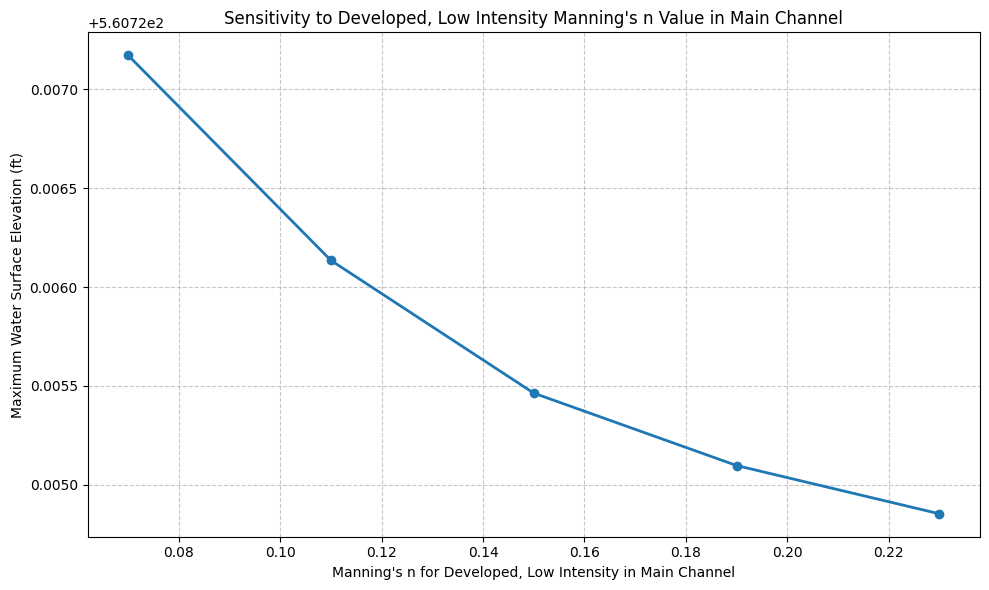

Created sensitivity plot for Developed, Low Intensity in Main Channel


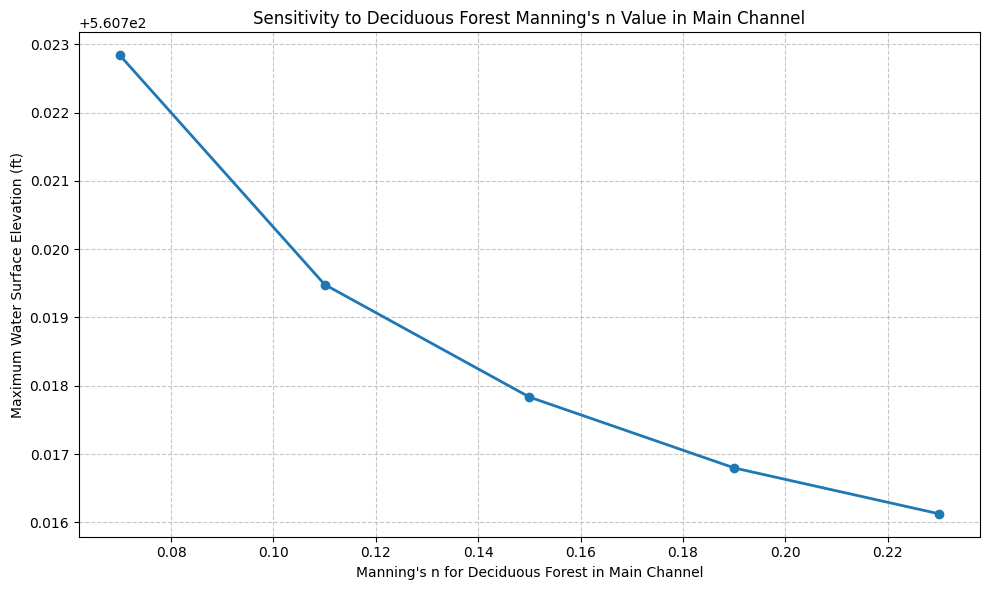

Created sensitivity plot for Deciduous Forest in Main Channel


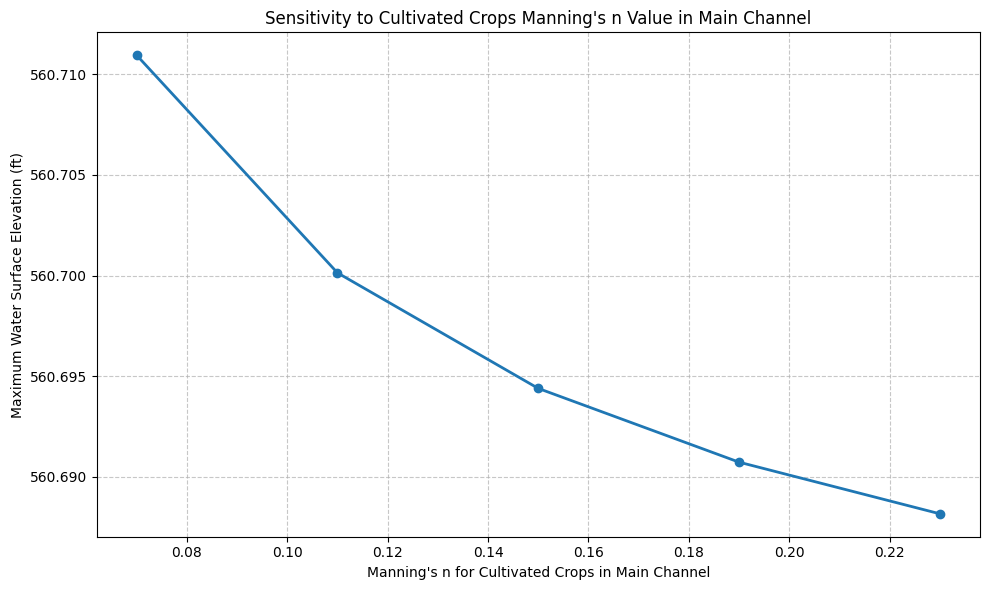

Created sensitivity plot for Cultivated Crops in Main Channel


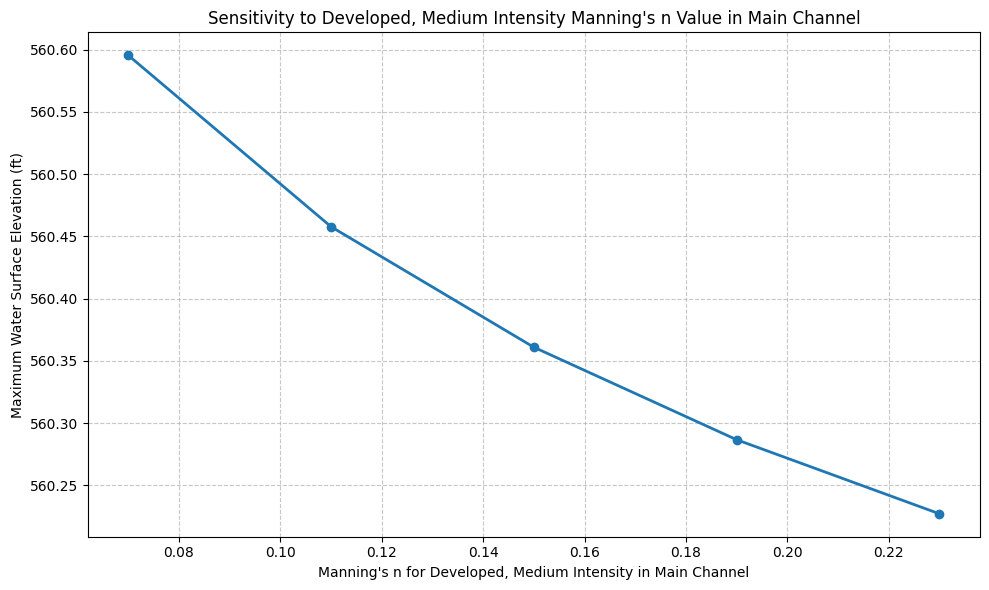

Created sensitivity plot for Developed, Medium Intensity in Main Channel


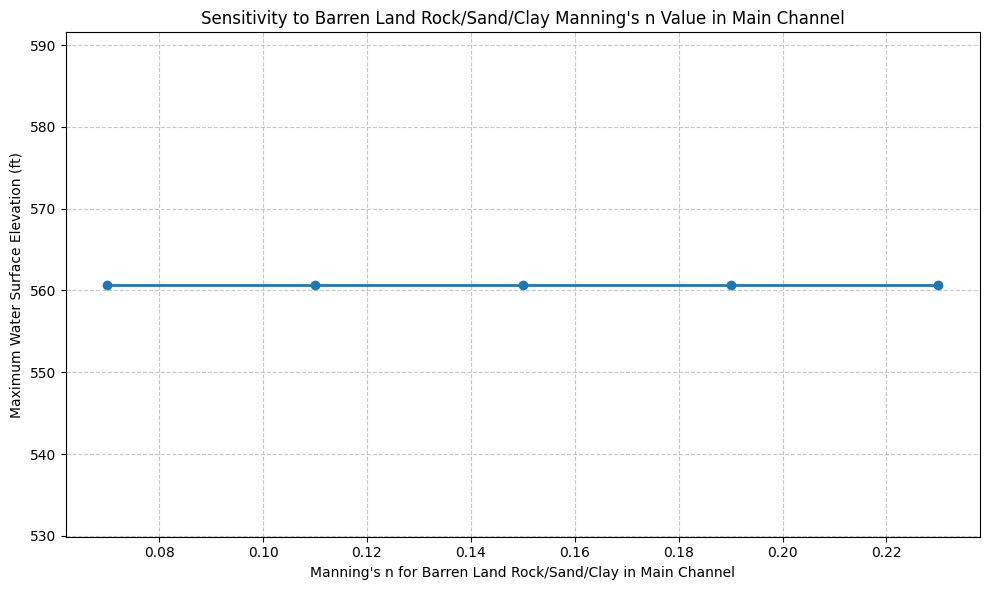

Created sensitivity plot for Barren Land Rock/Sand/Clay in Main Channel


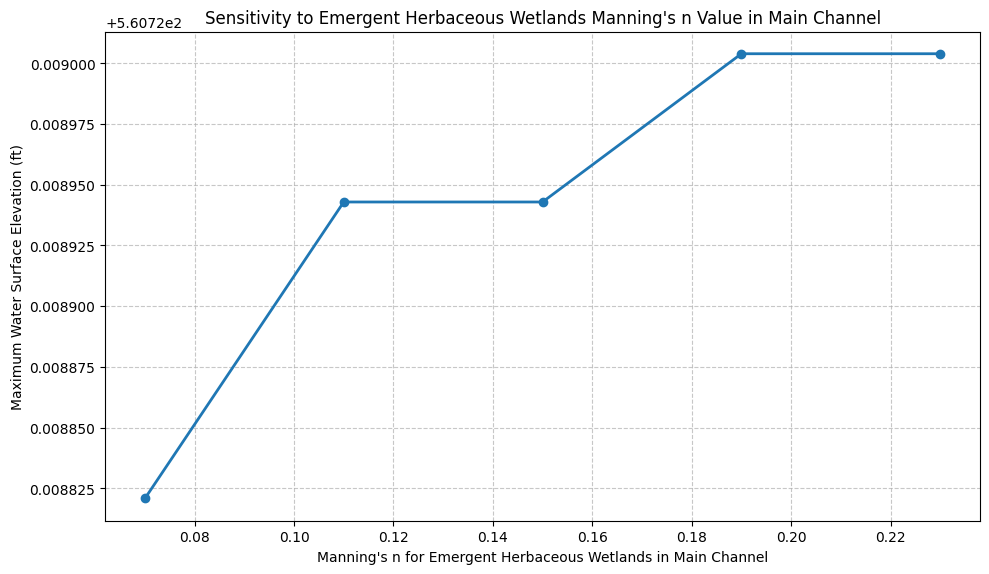

Created sensitivity plot for Emergent Herbaceous Wetlands in Main Channel


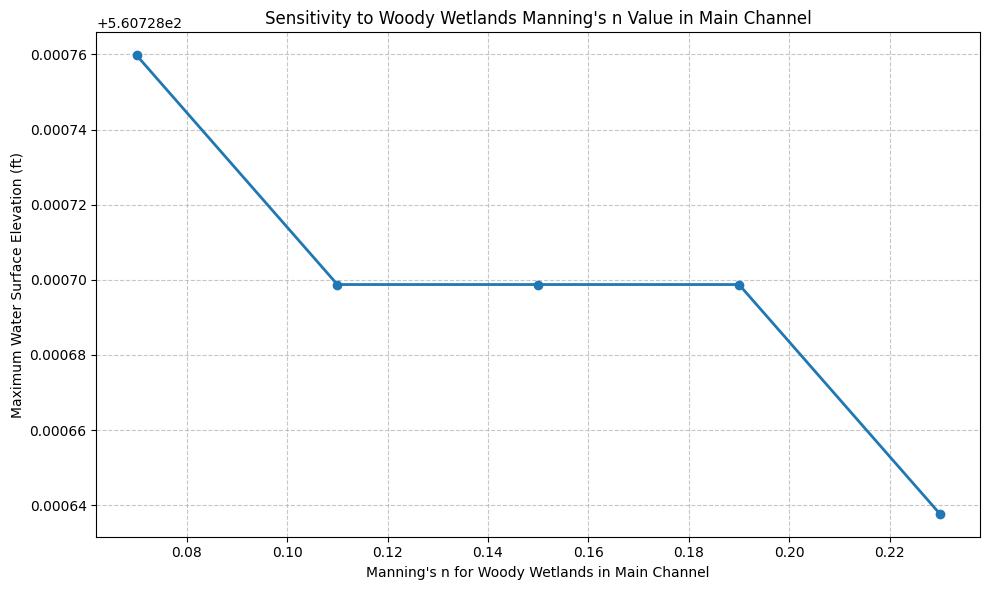

Created sensitivity plot for Woody Wetlands in Main Channel


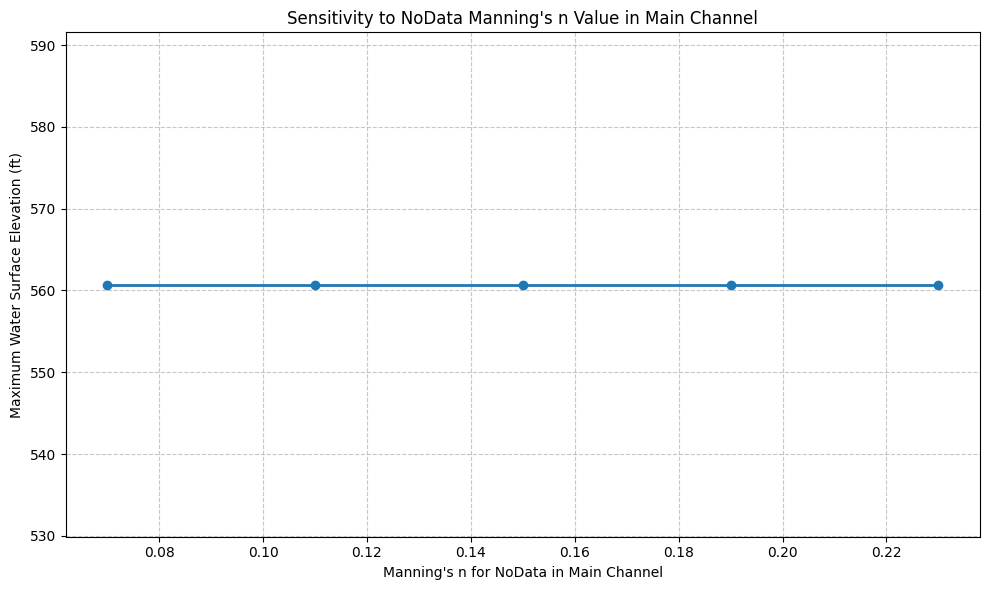

Created sensitivity plot for NoData in Main Channel


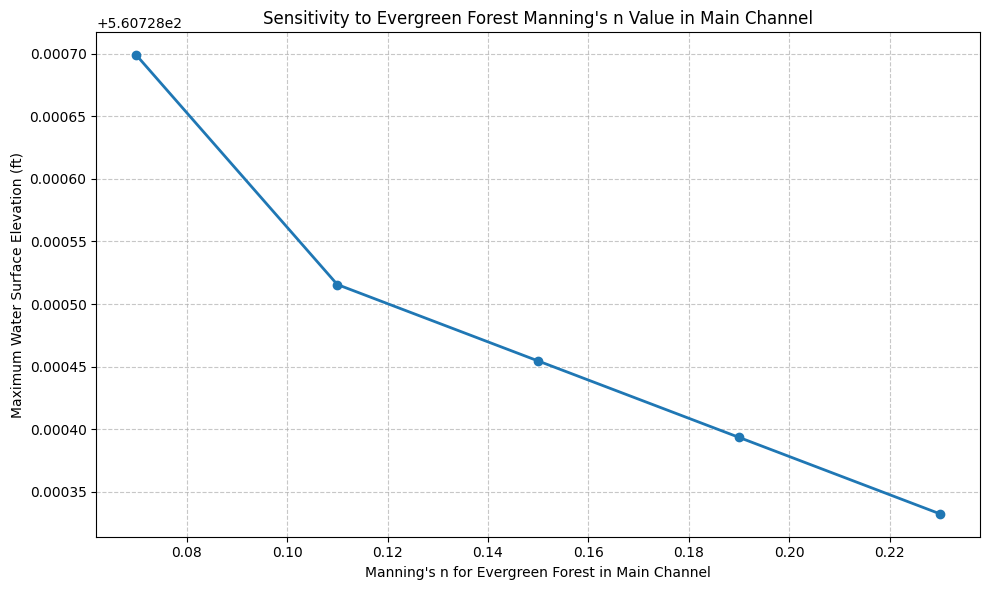

Created sensitivity plot for Evergreen Forest in Main Channel


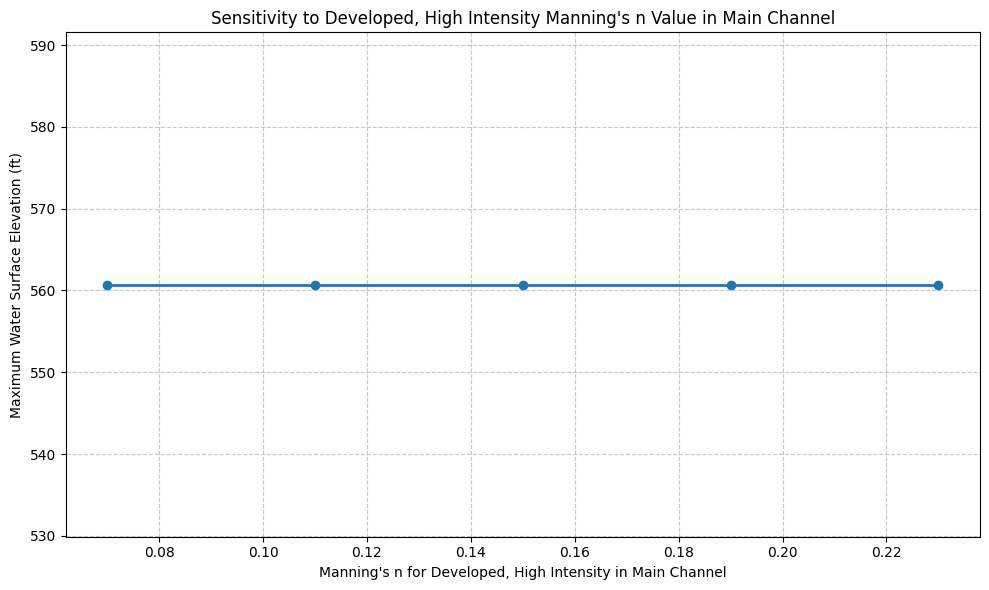

Created sensitivity plot for Developed, High Intensity in Main Channel


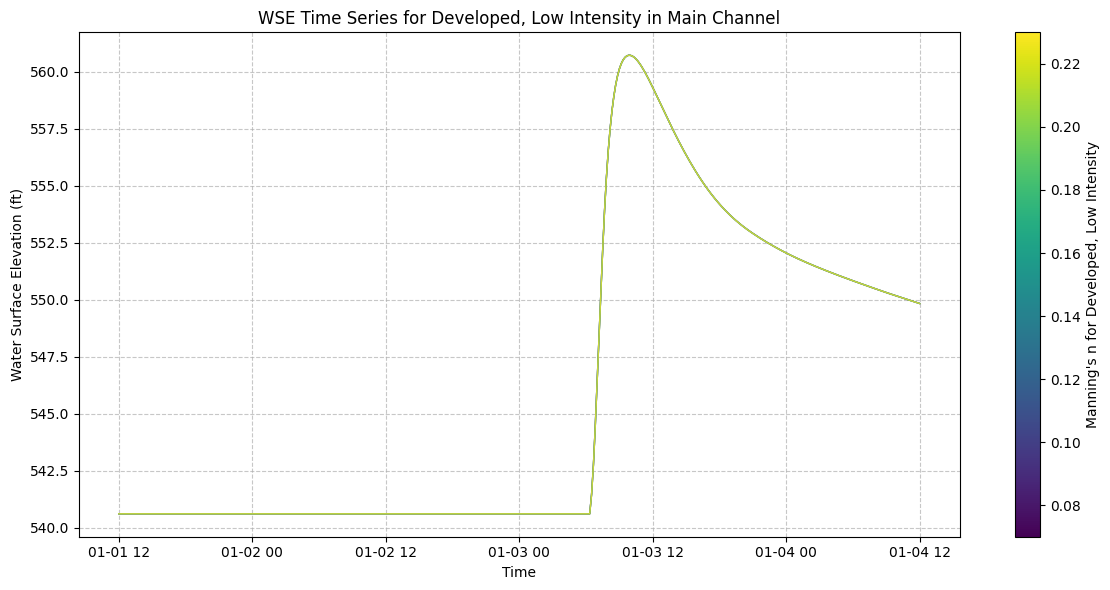

Created time series plot for Developed, Low Intensity in Main Channel


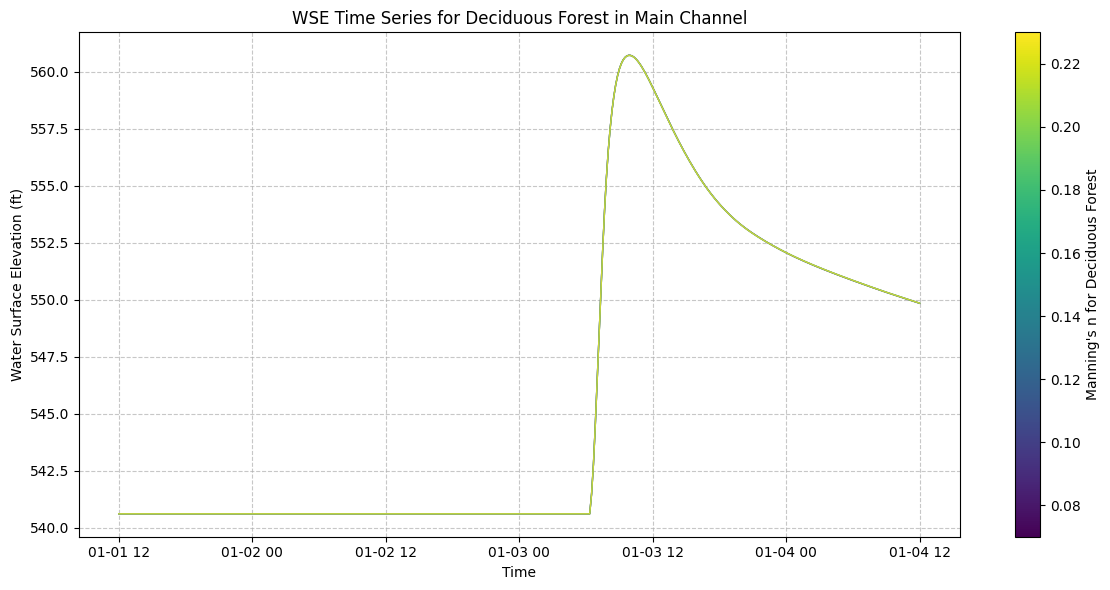

Created time series plot for Deciduous Forest in Main Channel


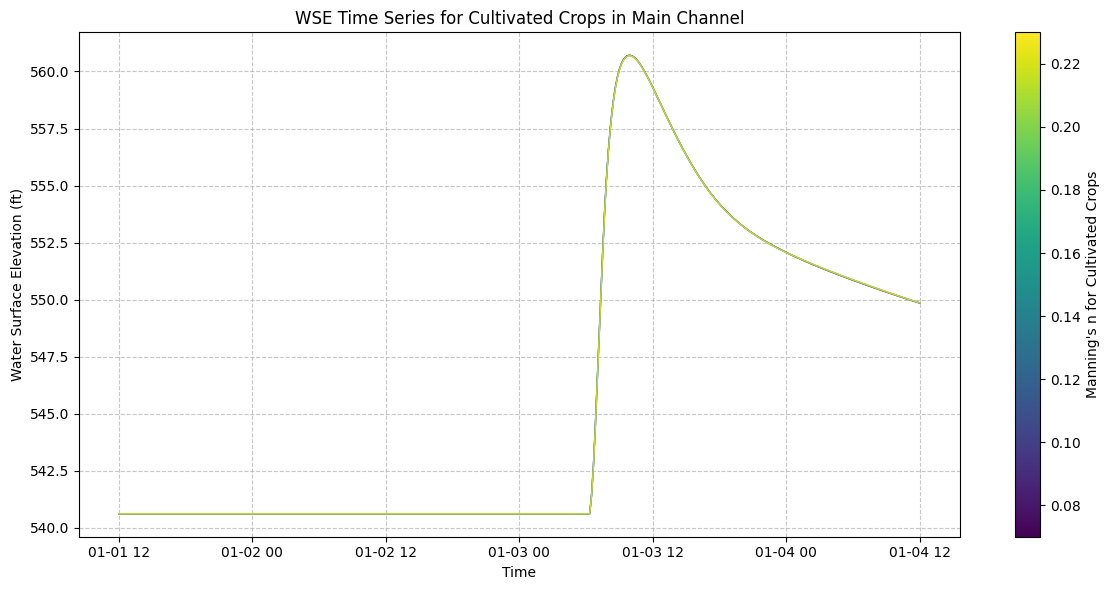

Created time series plot for Cultivated Crops in Main Channel


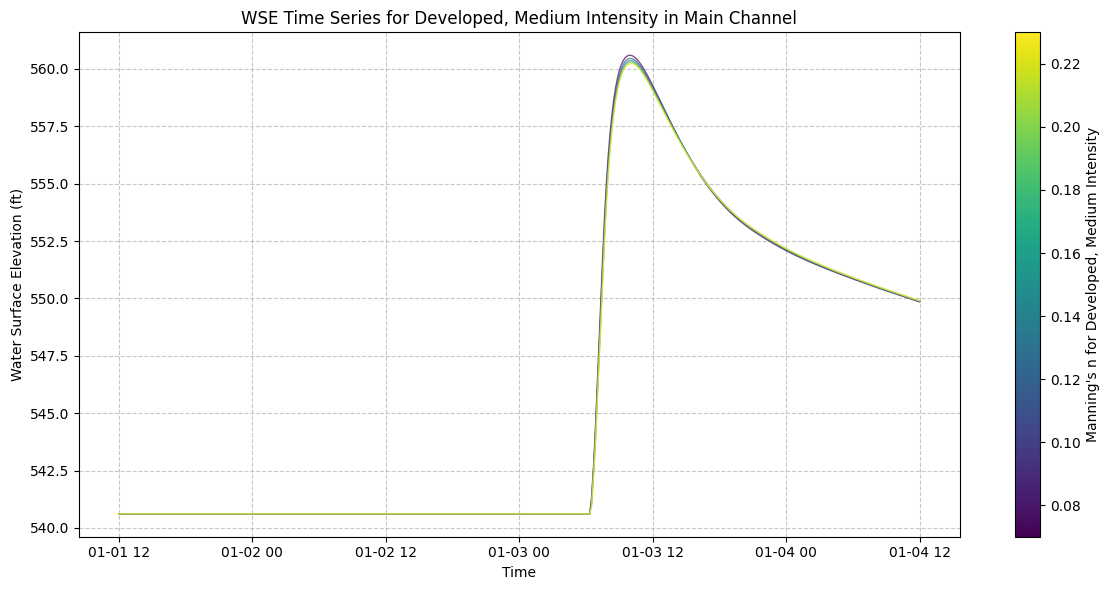

Created time series plot for Developed, Medium Intensity in Main Channel


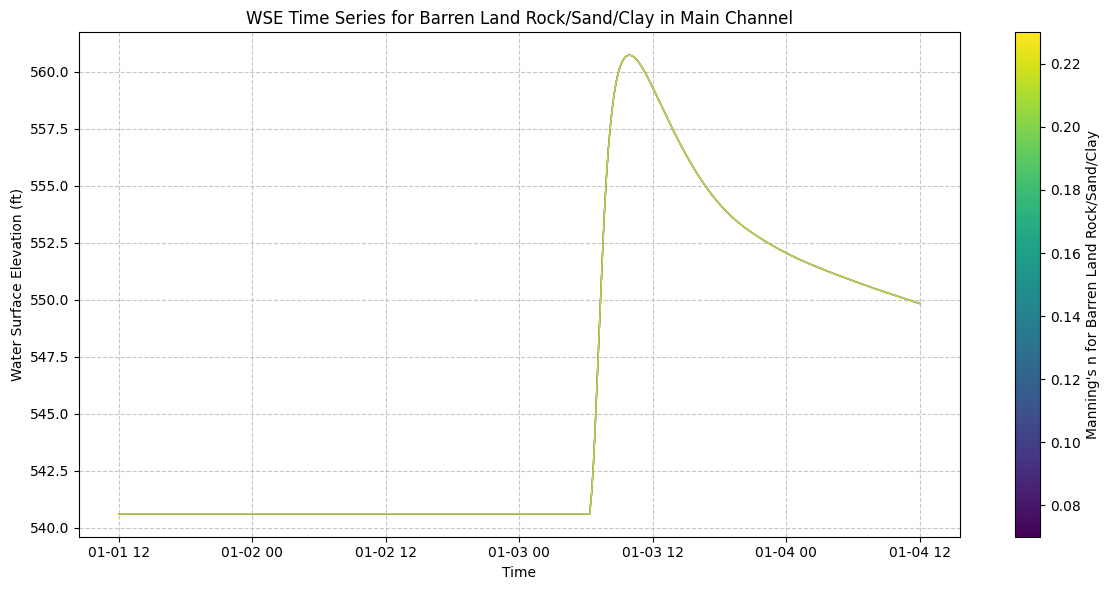

Created time series plot for Barren Land Rock/Sand/Clay in Main Channel


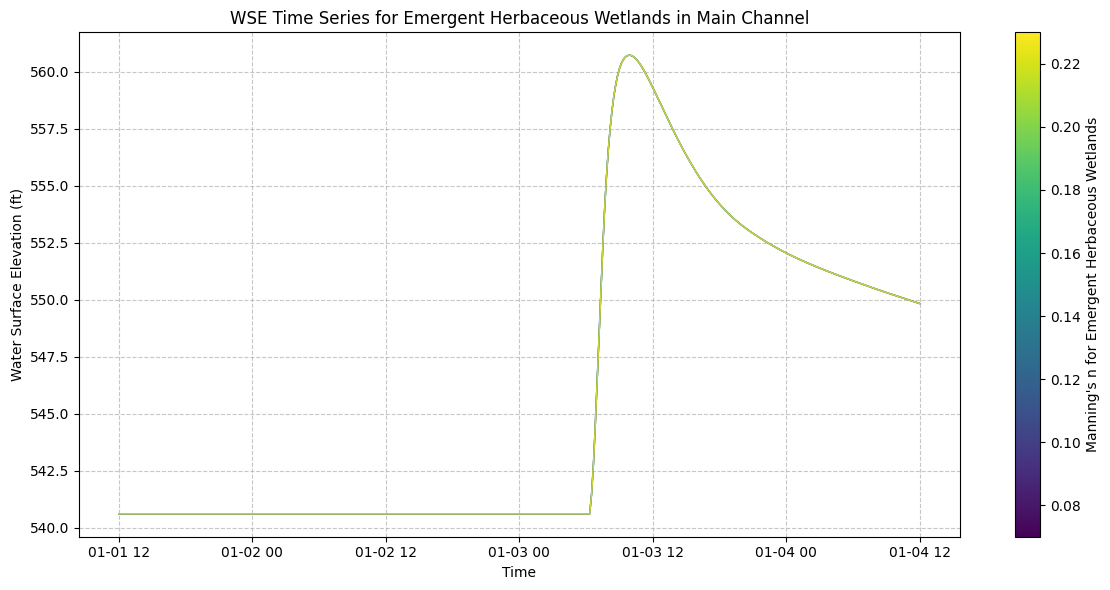

Created time series plot for Emergent Herbaceous Wetlands in Main Channel


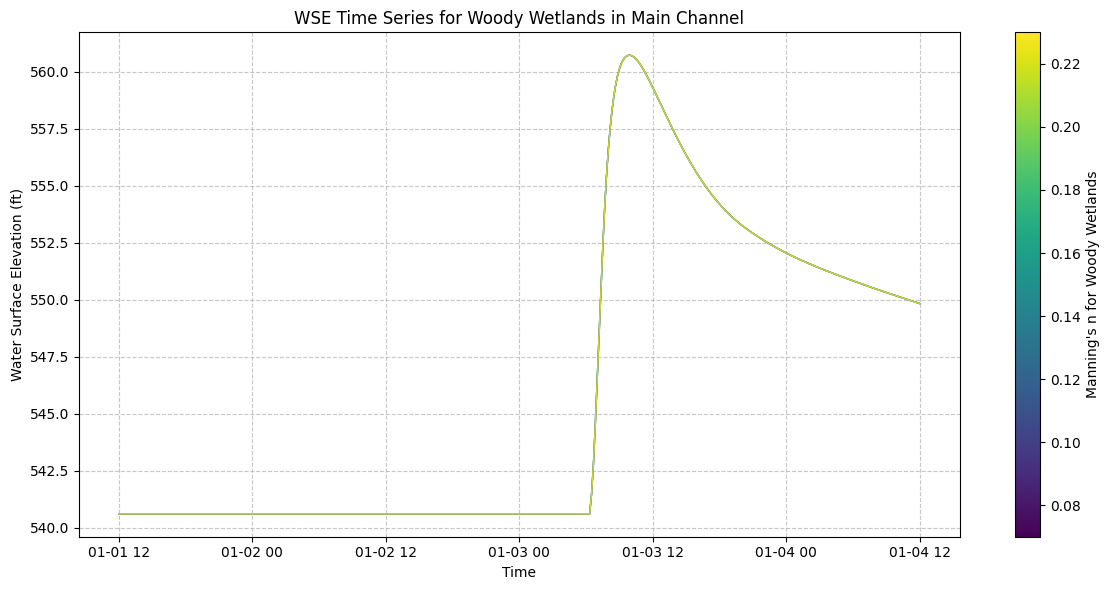

Created time series plot for Woody Wetlands in Main Channel


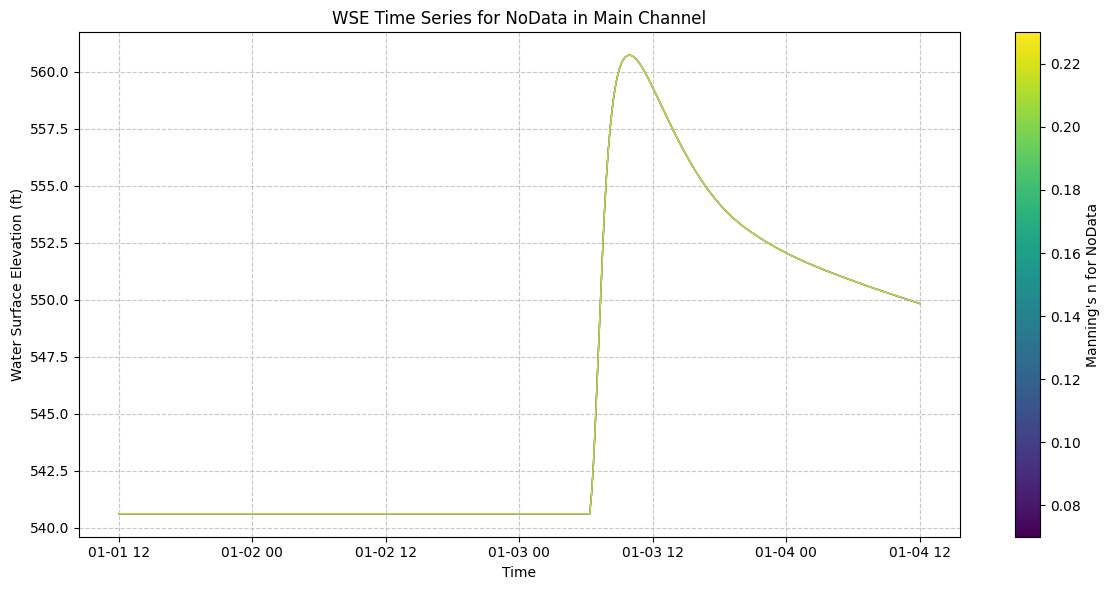

Created time series plot for NoData in Main Channel


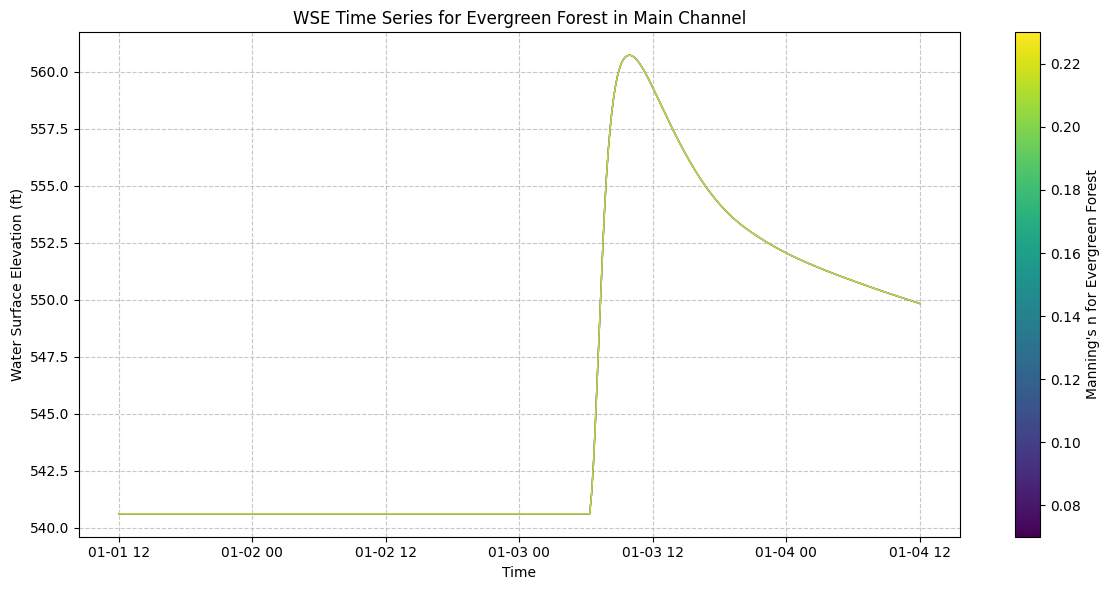

Created time series plot for Evergreen Forest in Main Channel


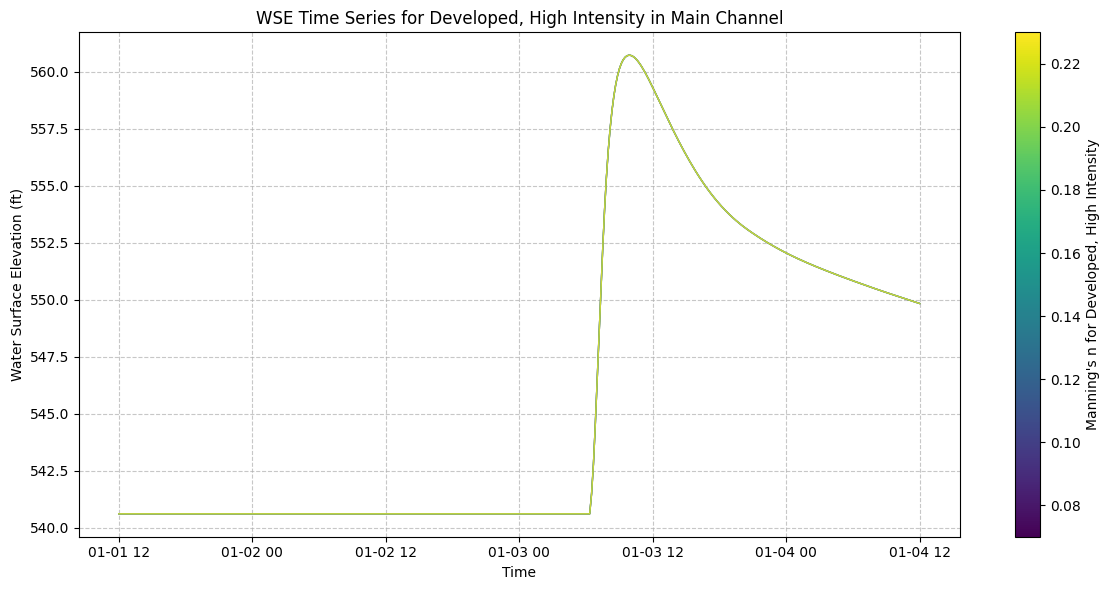

Created time series plot for Developed, High Intensity in Main Channel


In [13]:
# Example usage for Regional Overrides Sensitivity Analysis
# To run this, uncomment the code, adjust parameters as needed, and execute the cell

import shutil
import os
from pathlib import Path

# 1. Define source and destination paths
#    (We use the original extracted project as source, not the BOMIS one)
source_project_folder = Path(os.getcwd()) / "example_projects" / "BaldEagleCrkMulti2D"

# 2. Create a specific folder for Regional Override Multi-Interval Sensitivity (ROMIS)
project_folder = Path(os.getcwd()) / "example_projects" / "BaldEagleCrkMulti2D_ROMIS"

# Clean up if it already exists
if project_folder.exists():
    shutil.rmtree(project_folder)

# Copy the source project to the ROMIS folder
print(f"Creating dedicated ROMIS project folder...")
shutil.copytree(source_project_folder, project_folder)
print(f"Created: {project_folder}")

# 3. Initialize the ROMIS project
#    (This updates the global 'ras' object to point to this new folder, replacing the BOMIS context)
init_ras_project(project_folder, "6.6")

# Define parameters
template_plan = "03"  # Plan 03 has regional overrides
point_of_interest = (2081544, 365715) # Coordinates for regional analysis

# Run the regional sensitivity analysis
run_region_sensitivity_results = individual_landuse_sensitivity_region(
    project_folder=project_folder,
    template_plan=template_plan,
    point_of_interest=point_of_interest,
    area_threshold=10.0,  # Only analyze land uses covering at least 10% of the mesh area
    interval=0.04,       # Adjust interval to reduce the number of test values
    max_workers=4,
    num_cores=2,
    region_name="Main Channel",  # Specify a region or set to None for all regions
    output_folder="Regional_Landuse_Sensitivity",
    n_ranges=manning_minmax_df
)


In [ ]:
# Print summary information
if run_region_sensitivity_results:
    print("\nAnalysis complete! Results saved to:", run_region_sensitivity_results['output_folder'])
    if 'significant_landuses' in run_region_sensitivity_results:
        print("\nSignificant land uses analyzed in regions:")
        print(run_region_sensitivity_results['significant_landuses'][['Land Cover Type', 'Percentage']])

-----

## Regional Override Sensitivity Results

### Interpreting Regional Results

The following plots show sensitivity analysis results for regional Manning's n overrides from the BaldEagleCrkMulti2D example project (Plan 03). The plots follow the same format as the base sensitivity results, but focus on parameters within specific calibration regions.

**Key Differences from Base Results:**
- Plots are labeled with both land cover type AND region name
- Changes affect only the specified region, not the entire mesh
- Sensitivity may be higher or lower depending on the hydraulic importance of the region
- Useful for understanding which regional parameters require the most careful calibration

**Regional vs. Base Comparison:**
- Compare the magnitude of water surface changes between regional and base sensitivity
- Regional parameters that cause large changes should be prioritized in calibration
- If a land cover has low sensitivity in a particular region, it may be acceptable to use default values

**Application to Your Models:**
- Identify which regions have the strongest influence on your points of interest
- Focus calibration efforts on high-sensitivity regions
- Consider simplifying regions with low sensitivity

---

### Results from BaldEagleCrkMulti2D, Plan 03 (Main Channel Region)

---

# Summary and Best Practices

## Key Takeaways

### Analysis Methodology

This notebook demonstrated two complementary approaches to Manning's n sensitivity analysis:

1. **Base Override Sensitivity**: Tests global land cover roughness parameters across the entire 2D mesh
2. **Regional Override Sensitivity**: Tests localized roughness parameters within specific calibration regions

Both approaches use literature-based ranges to ensure physically reasonable parameter variations and automatically generate comprehensive visualizations.

### Practical Applications

**When to Use Base Sensitivity:**
- Initial model exploration and parameter importance ranking
- Models with uniform land cover distributions
- Assessing global calibration uncertainty
- Identifying which land covers dominate model response

**When to Use Regional Sensitivity:**
- Main channel calibration (use bulk approach from notebook 105)
- Localized parameter testing in specific hydraulic zones
- Floodplain region calibration with distinct characteristics
- Focused calibration in areas of interest

### Calibration Workflow Recommendations

1. **Start with base sensitivity** to identify globally important land covers
2. **Rank parameters by sensitivity** - focus on land covers causing largest water surface changes
3. **Use regional sensitivity** for localized refinement in hydraulically important areas
4. **Iterate with observed data** - compare sensitivity results against measured water surfaces
5. **Document assumptions** - record which parameters were adjusted and why

### Computational Efficiency Tips

**Plan Count Management:**
- Use larger `interval` values (e.g., 0.02-0.05) to reduce plan count
- Increase `area_threshold` to focus only on dominant land covers
- Target specific regions rather than analyzing all regions simultaneously
- HEC-RAS limits projects to 99 plans maximum

**Parallel Execution:**
- Balance `max_workers` and `num_cores` based on available CPU and RAM
- Rule of thumb: `max_workers * num_cores ≤ total_logical_cores`
- Monitor system resources during execution
- Consider sequential execution for very large or memory-intensive models

### Output Files

Each analysis creates a structured output folder containing:
- `scenarios.csv`: Complete plan inventory with parameter values
- `max_water_surface_summary.csv`: Peak water surface elevations for all scenarios
- `timeseries_*.csv`: Complete hydrographs for each scenario
- `sensitivity_*.png`: Parameter sensitivity plots
- `timeseries_*.png`: Time series comparison plots

### Next Steps

- **Compare with observed data**: Use sensitivity plots to guide calibration toward measured values
- **Uncertainty quantification**: Analyze the range of results to understand prediction uncertainty
- **Spatial analysis**: Extract results at multiple points to understand spatial variability
- **Multi-objective calibration**: Consider multiple performance metrics beyond peak water surface

### Related Notebooks

- **Notebook 105**: Bulk Manning's n sensitivity analysis (recommended for main channel calibration)
- **Notebook 09**: Plan parameter operations for additional customization
- **Notebook 08**: Parallel execution techniques for large-scale analyses

---

## References

**Manning's n Value Resources:**
- Chow, V.T. (1959). Open-Channel Hydraulics. McGraw-Hill
- Arcement, G.J., & Schneider, V.R. (1989). Guide for Selecting Manning's Roughness Coefficients. USGS Water Supply Paper 2339
- HEC-RAS Hydraulic Reference Manual (current version)

**Sensitivity Analysis:**
- Saltelli, A., et al. (2008). Global Sensitivity Analysis: The Primer. Wiley
- Tate, E., et al. (2015). Uncertainty Analysis for Flood Risk Assessment. Natural Hazards

---

*End of Notebook*
